<a href="https://colab.research.google.com/github/shuyaguan/0826/blob/main/Riya%26Shuya_DeepLearning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MUSA 650 Final Assignment Proposal: Remote Sensing Solution for Urban Planning**

## **Flood Mapping for Urban Disruptions and Emergency Response**

Shuya Guan and Riya Saini


# 1. Dataset Exploration

In [7]:
# Essential imports for data exploration
import os
import glob
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import rasterio
from torchvision import transforms

from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'rasterio'

In [ ]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define dataset directory
data_dir = "/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD"

In [ ]:
# List all TIFF files recursively
tif_files = glob.glob(os.path.join(data_dir, "**/*.tif"), recursive=True)
print(f"Total TIFF files found: {len(tif_files)}")

# Print sample file paths
print("Sample file paths:")
for f in tif_files[:5]:
    print(f)

s1_files = [f for f in tif_files if "S1" in f]
s2_files = [f for f in tif_files if "S2" in f]
print(f"Sentinel-1 (S1) images : {len(s1_files)}")
print(f"Sentinel-2 (S2) images : {len(s2_files)}")

Total TIFF files found: 28300
Sample file paths:
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/new.tif
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/0005/S1A_IW_GRDH_1SDV_20181216T172604_20181216T172629_025053_02C3AD_6EEA_corrected_VH.tif
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/0005/S1A_IW_GRDH_1SDV_20181221T173347_20181221T173412_025126_02C648_A3BD_corrected_VH.tif
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/0005/S1A_IW_GRDH_1SDV_20181221T173347_20181221T173412_025126_02C648_A3BD_corrected_VV.tif
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/0005/S1A_IW_GRDH_1SDV_20181221T173412_20181221T173437_025126_02C648_B354_corrected_VV.tif
Sentinel-1 (S1) images : 4324
Sentinel-2 (S2) images : 23975


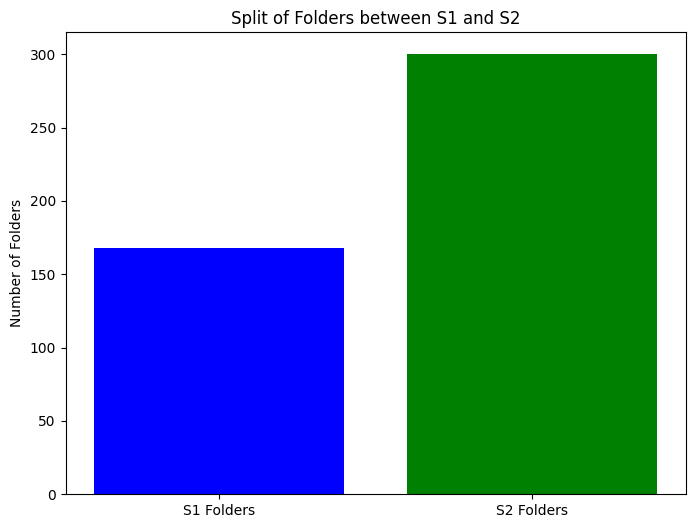

In [ ]:
# Count the number of S1 and S2 folders
s1_folder_count = len(set(os.path.dirname(f) for f in s1_files))
s2_folder_count = len(set(os.path.dirname(f) for f in s2_files))

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(["S1 Folders", "S2 Folders"], [s1_folder_count, s2_folder_count], color=['blue', 'green'])
plt.title("Split of Folders between S1 and S2")
plt.ylabel("Number of Folders")
plt.show()

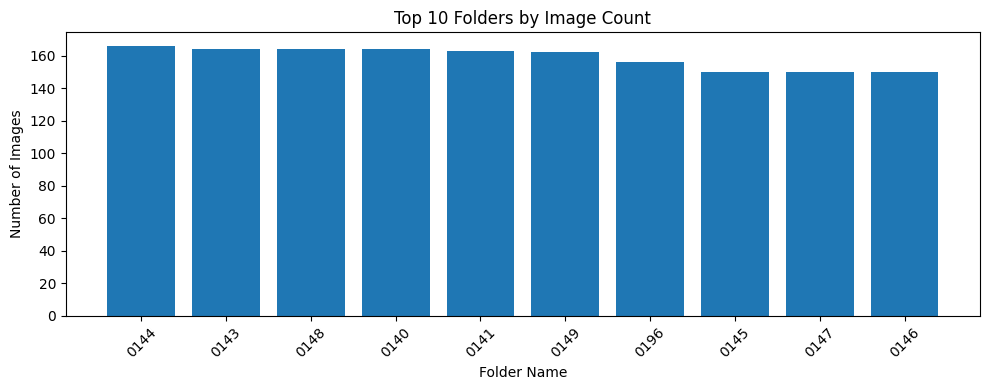

In [ ]:
# Plot distribution of folders
folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
folder_counts = Counter(folder_names)
df_folder_counts = pd.DataFrame(list(folder_counts.items()), columns=["Folder", "Count"])
df_folder_counts = df_folder_counts.sort_values("Count", ascending=False).head(10)

plt.figure(figsize=(10, 4))
plt.bar(df_folder_counts["Folder"], df_folder_counts["Count"])
plt.title("Top 10 Folders by Image Count")
plt.xlabel("Folder Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Load metadata JSON files
s1_json_path = os.path.join(data_dir, "S1list.json")
s2_json_path = os.path.join(data_dir, "S2list.json")

flood_labels = {}
# Load Sentinel-1 metadata
if os.path.exists(s1_json_path):
    with open(s1_json_path, "r") as f:
        s1_data = json.load(f)

    # Extract flood labels
    for folder, details in s1_data.items():
        flood_status = any(
            entry.get("FLOODING", False)
            for key, entry in details.items()
            if isinstance(entry, dict) and "FLOODING" in entry
        )
        flood_labels[folder] = int(flood_status)

# Load Sentinel-2 metadata
if os.path.exists(s2_json_path):
    with open(s2_json_path, "r") as f:
        s2_data = json.load(f)

    # Update flood labels
    for folder, details in s2_data.items():
        flood_status = any(
            entry.get("FLOODING", False)
            for key, entry in details.items()
            if isinstance(entry, dict) and "FLOODING" in entry
        )
        flood_labels[folder] = int(flood_status)

Flood Label Mapping (Sample):
Folder: 0063, Flooding: 0
Folder: 0200, Flooding: 1
Folder: 0004, Flooding: 0
Folder: 0307, Flooding: 1
Folder: 0167, Flooding: 1
Folder: 0205, Flooding: 1
Folder: 0166, Flooding: 1
Folder: 0240, Flooding: 1
Folder: 0123, Flooding: 0
Folder: 61, Flooding: 1
Flooded images: 17967
Non-flooded images: 10333
Number of flooded images: 17967
Number of non-flooded images: 10333


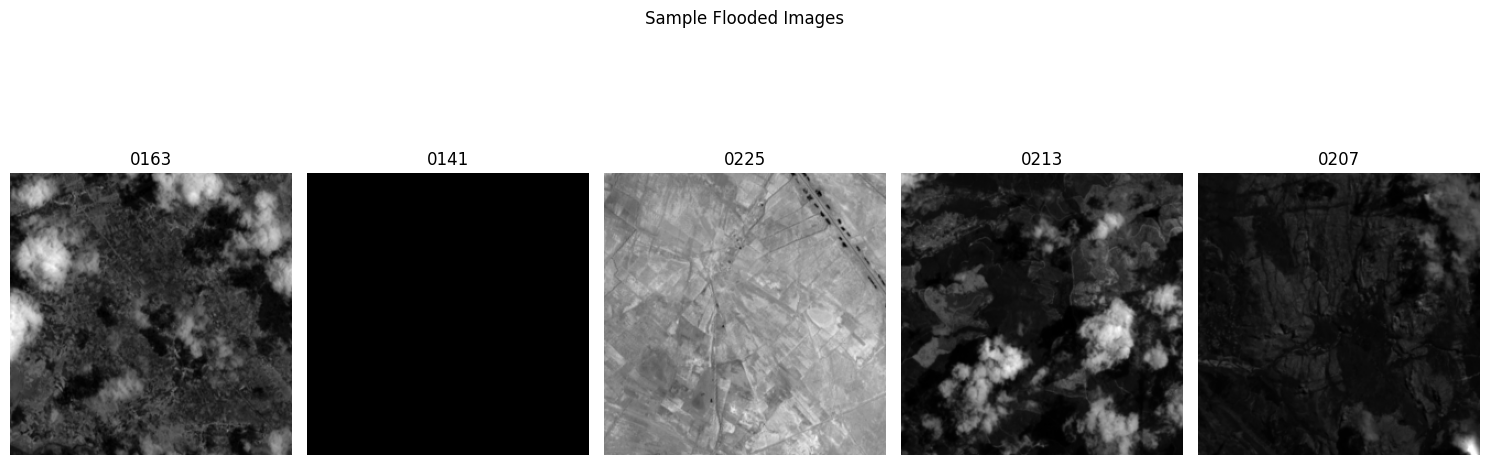

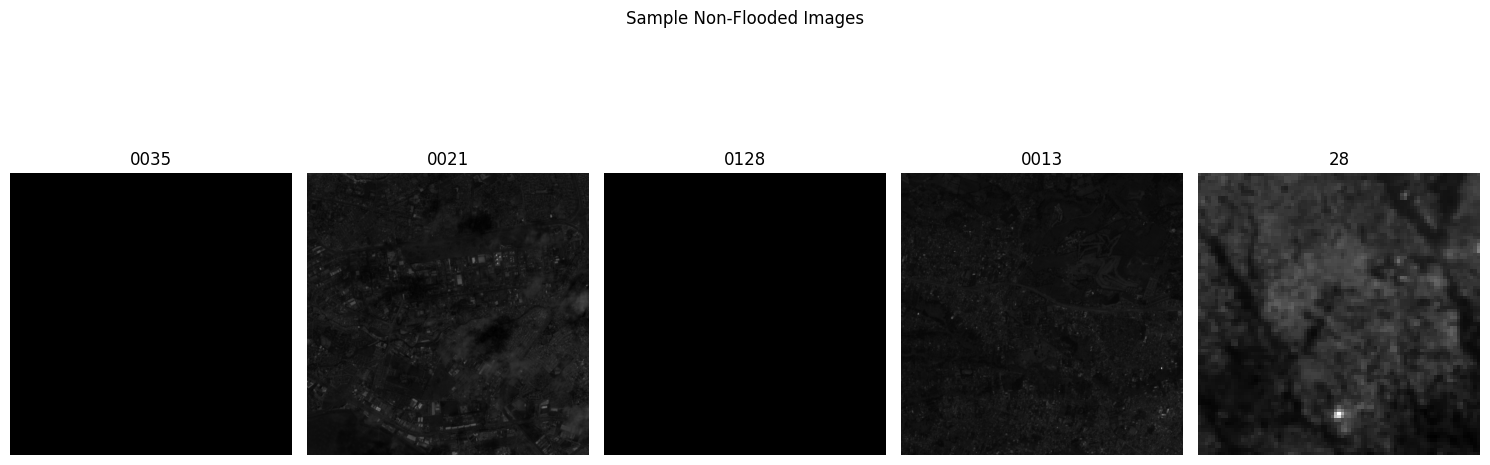

In [ ]:
# Display sample of flood labels
print("Flood Label Mapping (Sample):")
for folder, label in list(flood_labels.items())[:10]:
    print(f"Folder: {folder}, Flooding: {label}")

# Get label distribution
dataset_folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
mapped_labels = [flood_labels.get(folder, 0) for folder in dataset_folder_names]
label_counts = Counter(mapped_labels)
print(f"Flooded images: {label_counts[1]}")
print(f"Non-flooded images: {label_counts[0]}")

# Function to load and process images
def load_raw_greyscale_image(image_filepath):
    try:
        with rasterio.open(image_filepath) as src:
            image_data = src.read(1).astype(float)

        # Contrast stretching
        pixel_min = np.nanmin(image_data)
        pixel_max = np.nanmax(image_data)

        if pixel_max > pixel_min:
            stretched_image = (image_data - pixel_min) / (pixel_max - pixel_min)
        else:
            stretched_image = np.zeros_like(image_data)

        # Convert to 8-bit
        greyscale_image = (stretched_image * 255).clip(0, 255).astype(np.uint8)
        return greyscale_image
    except Exception as e:
        print(f"Error loading {image_filepath}: {e}")
        return np.zeros((256, 256), dtype=np.uint8)  # Return empty image on error

# Split files by label
flooded_files = [f for f in tif_files if flood_labels.get(os.path.basename(os.path.dirname(f)), 0) == 1]
non_flooded_files = [f for f in tif_files if flood_labels.get(os.path.basename(os.path.dirname(f)), 0) == 0]

print("Number of flooded images:", len(flooded_files))
print("Number of non-flooded images:", len(non_flooded_files))

# Display sample images
def display_sample_images(image_files, title, num_samples=5):
    # Randomly sample images if we have more than needed
    if len(image_files) > num_samples:
        sample_files = random.sample(image_files, num_samples)
    else:
        sample_files = image_files

    plt.figure(figsize=(15, 6))
    for idx, image_path in enumerate(sample_files):
        greyscale_img = load_raw_greyscale_image(image_path)
        plt.subplot(1, num_samples, idx+1)
        plt.imshow(greyscale_img, cmap="gray")
        plt.title(os.path.basename(os.path.dirname(image_path)))
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(flooded_files, "Sample Flooded Images")
display_sample_images(non_flooded_files, "Sample Non-Flooded Images")

The script successfully found 28,300 TIFF files in the dataset directory, with sample paths indicating both Sentinel-1 (S1) radar images in different polarizations (VV and VH) and potentially Sentinel-2 optical images. The dataset contains images organized in numbered folders (like 0005, 0063, etc.).The flood label mapping extracted from the metadata shows a binary classification where 1 indicates flooded areas and 0 indicates non-flooded areas. Based on this mapping, the dataset contains 17,967 flooded images (approximately 63%) and 10,333 non-flooded images (approximately 37%).

The visualizations of sample images show noticeable differences between flooded and non-flooded areas, with flooded images typically showing more distinct patterns of water bodies and different texture characteristics, though some images appear very dark and may require additional preprocessing to enhance features.

In [ ]:
#Optional: For Sentinel-1 radar (SAR) data
#You can visualize radar data like this (single band or false-color combo):

def show_sar_bands(image_path):
    with rasterio.open(image_path) as src:
        img = src.read(1)
    plt.imshow(img, cmap="gray")
    plt.title("SAR (VV or VH)")
    plt.axis("off")
    plt.show()

#Or if you have both VV and VH, do a false-color:

def show_sar_rgb(vv_path, vh_path):
    with rasterio.open(vv_path) as src1, rasterio.open(vh_path) as src2:
        vv = src1.read(1)
        vh = src2.read(1)
        diff = vv - vh
        img = np.stack([vv, vh, diff], axis=-1)
        img = img.astype(np.uint8)

    plt.imshow(img)
    plt.title("SAR False Color (VV, VH, VV-VH)")
    plt.axis("off")
    plt.show()

# 2. Data Preprocessing Pipeline

Standard practice is:

Keep the dataset as raw as possible

Apply:

augmentation + resize/normalize for training

just resize/normalize for validation and test

By applying these transformations after splitting, you can:

Apply different transforms per subset

Make training robust (via augmentation)

Keep validation/test clean for fair evaluation

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

# Config
data_dir = "/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD"
all_folders = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
print(f"Found {len(all_folders)} folders.")

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

Found 335 folders.


In [ ]:
def read_rgb_from_folder(folder_path):
    try:
        files = [f for f in os.listdir(folder_path) if f.endswith(".tif") and "B0" in f]

        # Organize by date
        band_dict = {}
        for f in files:
            parts = f.split("_")
            if len(parts) < 3:
                continue  # Skip unexpected filenames
            date = parts[1]
            band = parts[2].replace(".tif", "")
            band_dict.setdefault(date, {})[band] = f

        # Find the first valid date with B02, B03, B04
        for date, bands in band_dict.items():
            if all(b in bands for b in ["B02", "B03", "B04"]):
                r_path = os.path.join(folder_path, bands["B04"])
                g_path = os.path.join(folder_path, bands["B03"])
                b_path = os.path.join(folder_path, bands["B02"])

                r = rasterio.open(r_path).read(1).astype(np.float32)
                g = rasterio.open(g_path).read(1).astype(np.float32)
                b = rasterio.open(b_path).read(1).astype(np.float32)

                # Normalize using percentile stretch
                def normalize_band(band):
                    p2, p98 = np.percentile(band, (2, 98))
                    band = np.clip((band - p2) / (p98 - p2 + 1e-5), 0, 1)
                    return band

                r, g, b = normalize_band(r), normalize_band(g), normalize_band(b)

                rgb = np.stack([r, g, b], axis=-1)
                rgb = (rgb * 255).astype(np.uint8)
                return Image.fromarray(rgb)

        raise RuntimeError("No common date with all 3 bands found.")

    except Exception as e:
        raise RuntimeError(f"Error reading RGB bands in {folder_path}: {e}")

In [ ]:
import os
from collections import defaultdict

def is_valid_folder(folder_path):
    tif_files = [f for f in os.listdir(folder_path) if f.endswith(".tif") and "B0" in f]
    band_dates = defaultdict(set)

    for file in tif_files:
        parts = file.split('_')
        if len(parts) < 3:
            continue
        _, date, band = parts[0], parts[1], parts[2].replace(".tif", "")
        band_dates[date].add(band)

    for date, bands in band_dates.items():
        if {'B02', 'B03', 'B04'}.issubset(bands):
            return True  # Valid: has all 3 bands for one date

    return False  # No date had all 3 bands

In [ ]:
from tqdm import tqdm
folder_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))] # Define folder_paths
valid_folders = []
invalid_folders = []

for folder in tqdm(folder_paths):
    if is_valid_folder(folder):
        valid_folders.append(folder)
    else:
        invalid_folders.append(folder)

print(f" Valid folders: {len(valid_folders)} / {len(folder_paths)}")

100%|██████████| 335/335 [00:01<00:00, 271.65it/s]

✅ Valid folders: 300 / 335


This uses ESA's recommendation for reflectance scaling (assuming input is uint16). You could exclude or mark cloudy samples to improve learning quality.

2. Try different normalization methods
If 2–98% percentile stretch is too aggressive, you could: band = np.clip(band / 10000.0, 0, 1)

you need to select a single date from the available ones in each folder, because each RGB image must be composed from bands (B02, B03, B04) captured on the same day. Sentinel-2 takes images on different days, and having mismatched timestamps across bands can lead to corrupted or meaningless RGB outputs.

300 valid folders out of 335 means your dataset is now clean and ready for model training using only Sentinel-2 RGB bands with matching acquisition dates.

In [ ]:
# Shuffle and split ONLY valid folders
random.shuffle(valid_folders)
train_size = int(0.7 * len(valid_folders))
val_size = int(0.15 * len(valid_folders))
test_size = len(valid_folders) - train_size - val_size

train_folders = valid_folders[:train_size]
val_folders = valid_folders[train_size:train_size + val_size]
test_folders = valid_folders[train_size + val_size:]

In [ ]:
# Dataset
class Sentinel2RGBDataset(Dataset):
    def __init__(self, folder_paths, label_map, transform=None):
        self.folder_paths = folder_paths
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.folder_paths)

    def __getitem__(self, idx):
        tries = 0
        while tries < 5:
            folder = self.folder_paths[idx]
            folder_name = os.path.basename(folder)
            label = self.label_map.get(folder_name, 0)
            try:
                image = read_rgb_from_folder(folder)
                if self.transform:
                    image = self.transform(image)
                return image, label
            except Exception as e:
                print(f"Skipping folder {folder}: {e}")
                idx = (idx + 1) % len(self.folder_paths)
                tries += 1
        return torch.zeros((3, 224, 224)), 0  # fallback


# Datasets & Loaders
train_dataset = Sentinel2RGBDataset(train_folders, flood_labels, transform=train_transform)
val_dataset = Sentinel2RGBDataset(val_folders, flood_labels, transform=val_test_transform)
test_dataset = Sentinel2RGBDataset(test_folders, flood_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check a sample
images, labels = next(iter(train_loader))
print(f"Sample batch shape: {images.shape}, labels: {labels[:5]}")

Sample batch shape: torch.Size([32, 3, 224, 224]), labels: tensor([0, 1, 1, 1, 0])


In [ ]:
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 210, Val: 45, Test: 45


This code prepares satellite images for a flood detection system. First, it resizes all images to the same size (224×224 pixels) so they fit what the neural network expects. Then it converts the images to a format called tensors that deep learning models can work with, and normalizes the pixel values to make the training process more effective. The code splits the 28,300 images into three groups: **70%** for training the model, **15%** for checking its progress during training, and **15%** for final testing.

1. Each folder = 1 spatial-temporal sample
In Sen12Flood, each folder corresponds to a unique scene at a specific time and location. That means:

The bands B04, B03, B02 inside a folder are all from the same spatial-temporal context.

If you split at the image level instead of the folder level, you risk data leakage — similar-looking images (e.g., same area, different bands or timestamps) could end up in both training and test sets.

2. Spatial autocorrelation
Remote sensing data often suffers from spatial autocorrelation — nearby pixels or scenes are not independent. So randomly splitting pixels or even individual images across folders can make the test performance look better than it actually is.

That’s why it’s best practice to:

Split by scene or folder, not by image.

Ensure each split contains unique scenes.

3. Sen12Flood follows this pattern
Sen12Flood isn't split randomly at the pixel or image level either. It’s typically split by folders/scenes for the same reason — to prevent leakage and ensure generalization across different geographic locations.

So in short: Yes, your approach is the right way to handle Sen12Flood. Avoid splitting the dataset at the image level, especially in geospatial tasks. Folder-level splits based on scene ensure valid, non-leaky training and evaluation.

In [6]:
# Helper to unnormalize the image for display
def unnormalize(tensor):
    """Convert normalized image tensor back to [0, 1] for display"""
    tensor = tensor * 0.5 + 0.5  # Assuming normalization mean=0.5, std=0.5
    return tensor

# Define class label names for visualization
label_names = {v: k for k, v in flood_labels.items()}  # e.g., {0: 'nonflooded', 1: 'flooded'}

# Plot a few images from the training dataset
def plot_samples(dataset, num_samples=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        image, label = dataset[i]
        image = unnormalize(image)  # Undo normalization
        image_np = image.permute(1, 2, 0).numpy()  # Convert to HWC format for plotting

        plt.subplot(3, 3, i + 1)
        plt.imshow(image_np)
        plt.title(f"Label: {label_names.get(label, label)}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show samples
plot_samples(train_dataset)

NameError: name 'flood_labels' is not defined

UN-SPIDER Workflow
United Nations Platform for Space-based Information for Disaster Management and Emergency Response

🔍 Model Type: Threshold-based / rule-based with optional ML integration
Core Idea: Uses Sentinel-1 SAR (VV/VH) backscatter before and after the event.

Methodology:

Pre-event and post-event image comparison

Apply thresholds (e.g., 2–3 dB difference) to detect permanent water vs flooded areas

Uses Normalized Difference Flood Index (NDFI) or ratio/mean change detection

📌 Sometimes integrates:
Decision trees

Simple classifiers (Random Forests, SVM) — if training data available

Often paired with GIS layers (elevation, land use)

Goal: Simple, operational, fast – especially when computational power is limited in disaster zones

WorldFloods (Oxford / Frontier Development Lab)
🔍 Model Type: Deep Learning (U-Net)
Developed as part of ESA’s WorldFloods with Oxford and the UN.

Architecture:

U-Net convolutional neural network

Takes Sentinel-1 SAR (VV/VH) images as input

Outputs a pixel-wise binary flood mask

Key Features:

Trained on 13 flood events across different countries

Multi-temporal Sentinel-1 inputs (before, during, after)

Works well in cloud-prone areas (where optical imagery fails)

Model Characteristics:

Input: 2-3 SAR bands (VV before, VV after, VH after)

Output: Raster map of flooded areas (same size as input)

Can run on low-cost hardware (e.g., Raspberry Pi)



**Model Part start from here:**

Model	Type	Use Case Fit	Notes
CNN	Deep learning	Image-level classification	Great for detecting if an image (or patch) is flooded
U-Net	Deep learning	Pixel-level segmentation	Ideal for flood masks — where is the water?
Random Forest	Traditional ML	Patch or feature-based classification	Good baseline, but needs flattening + hand-crafted features

Random Forest

In [ ]:
# Step 1: Convert Images to Flattened Numpy Arrays
from tqdm import tqdm

def loader_to_numpy(dataloader):
    images_list, labels_list = [], []
    for images, labels in tqdm(dataloader):
        imgs_np = images.numpy()  # Convert to numpy
        lbls_np = labels.numpy()
        imgs_np = imgs_np.reshape(imgs_np.shape[0], -1)  # Flatten: (3, 224, 224) → (150528,)
        images_list.append(imgs_np)
        labels_list.append(lbls_np)
    return np.vstack(images_list), np.concatenate(labels_list)

# Extract training and testing data
X_train, y_train = loader_to_numpy(train_loader)
X_test, y_test = loader_to_numpy(test_loader)


100%|██████████| 2/2 [00:18<00:00,  9.20s/it]


In [ ]:
# Step 2: Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train
rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

used this as reference: https://nhess.copernicus.org/articles/21/807/2021/ for random forest features

🔍 Random Forest Performance on Test Set:
Accuracy : 0.7111
Precision: 0.7353
Recall   : 0.8621
F1-score : 0.7937

📋 Classification Report:
              precision    recall  f1-score   support

 non-flooded       0.64      0.44      0.52        16
     flooded       0.74      0.86      0.79        29

    accuracy                           0.71        45
   macro avg       0.69      0.65      0.66        45
weighted avg       0.70      0.71      0.70        45



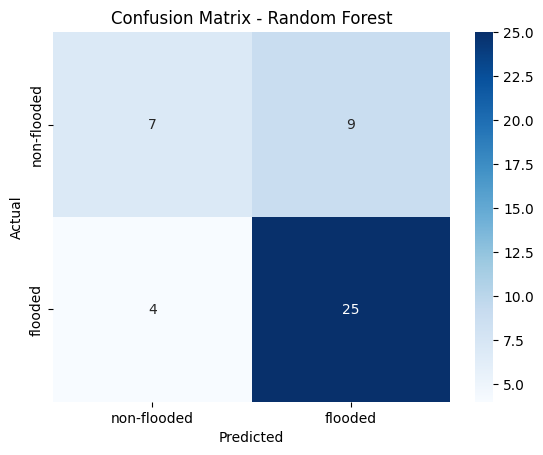

In [ ]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("🔍 Random Forest Performance on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# Print classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["non-flooded", "flooded"]))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-flooded", "flooded"], yticklabels=["non-flooded", "flooded"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


# SmallFlood CNN

1. CNN – Image Classification
🔍 Goal:
Classify full image or patches into categories: flooded vs non-flooded.

✅ Pipeline:
Input: RGB (or SAR) tiles resized to 224x224

Model: Simple CNN or pre-trained ResNet/VGG via Keras

Output: Single label (flooded = 1, nonflooded = 0)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmallFloodCNN(nn.Module):
    def __init__(self):
        super(SmallFloodCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # (16, 224, 224)
        self.pool = nn.MaxPool2d(2, 2)  # → (16, 112, 112)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # (32, 112, 112) → (32, 56, 56)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (64, 28, 28)

        self.dropout = nn.Dropout(0.4)

        self.fc1 = nn.Linear(64 * 28 * 28, 64)
        self.fc2 = nn.Linear(64, 2)  # 2 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # (32, 56, 56)
        x = self.pool(F.relu(self.conv3(x)))  # (64, 28, 28)

        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallFloodCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f} - Train Acc: {train_acc:.2f}%")



In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = evaluate_model(model, test_loader)


Accuracy: 0.6444444444444445
Precision: 0.6444444444444445
Recall: 1.0
F1 Score: 0.7837837837837838
              precision    recall  f1-score   support

    No Flood       0.00      0.00      0.00        16
       Flood       0.64      1.00      0.78        29

    accuracy                           0.64        45
   macro avg       0.32      0.50      0.39        45
weighted avg       0.42      0.64      0.51        45



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


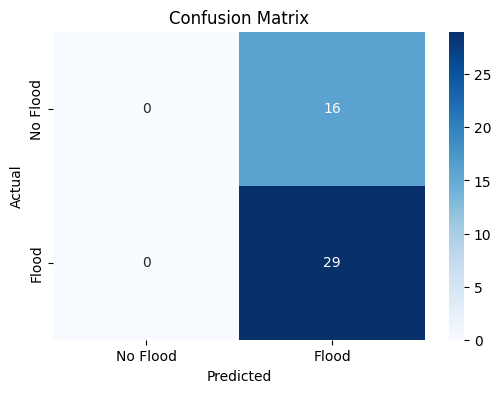

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

target_names = ['No Flood', 'Flood']
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Your model never predicts "No Flood", which causes:

Recall for "Flood" to be perfect (it never misses a flood).

But Precision suffers (it often mistakes No Flood for Flood).

This likely indicates class imbalance or bias in predictions.

# ResNet CNN

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pretrained ResNet18
class FloodResNet(nn.Module):
    def __init__(self):
        super(FloodResNet, self).__init__()
        self.base_model = models.resnet18(pretrained=True)

        # Modify final layer for binary classification
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, 2)  # Binary output

    def forward(self, x):
        return self.base_model(x)


In [ ]:
model = FloodResNet().to(device)

criterion = nn.CrossEntropyLoss()  # Since output is 2 logits
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.3MB/s]


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.3527
Epoch [2/10], Loss: 0.1749
Epoch [3/10], Loss: 0.1190
Epoch [4/10], Loss: 0.0888
Epoch [5/10], Loss: 0.1002
Epoch [6/10], Loss: 0.1197
Epoch [7/10], Loss: 0.0854
Epoch [8/10], Loss: 0.0783
Epoch [9/10], Loss: 0.0748
Epoch [10/10], Loss: 0.0687


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:\n", classification_report(all_labels, all_preds, digits=4))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


Accuracy: 0.8444444444444444
Classification Report:
               precision    recall  f1-score   support

           0     0.8947    0.7727    0.8293        22
           1     0.8077    0.9130    0.8571        23

    accuracy                         0.8444        45
   macro avg     0.8512    0.8429    0.8432        45
weighted avg     0.8502    0.8444    0.8435        45

Confusion Matrix:
 [[17  5]
 [ 2 21]]


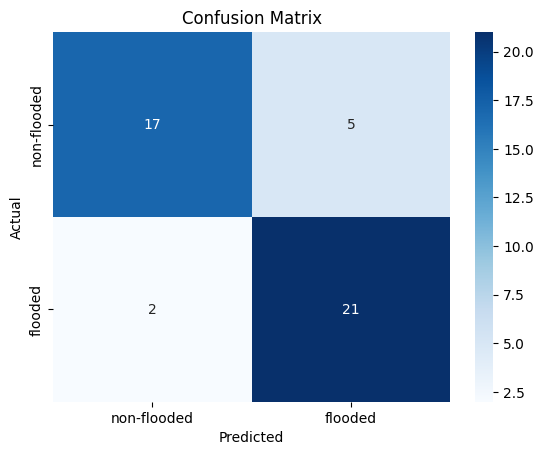

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = [[17, 5], [2, 21]]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-flooded", "flooded"], yticklabels=["non-flooded", "flooded"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# UNET

Your dataset is currently not suited for semantic segmentation (e.g., with U-Net), because:

U-Net requires pixel-level labels, but your data only includes imagery (no mask to learn from). CANNOT RUN U-NET

U-Net – Image Segmentation
🔍 Goal:
Predict a pixel-wise flood mask. Useful if SEN12FLOOD includes ground truth labels as masks.

✅ Pipeline:
Input: Image tiles (e.g., 256x256 or 512x512)

Model: U-Net (custom or segmentation_models library)

Output: Binary mask of same size as input

✅ Notes:
Your data must include segmentation masks.

Use binary cross-entropy or dice loss.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.final_conv(d1))


In [ ]:
model = UNet(in_channels=3, out_channels=1).to(device)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float()

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 224, 224])) is deprecated. Please ensure they have the same size.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_unet(model, dataloader, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1).float()  # (B, 1, H, W)

            outputs = model(images)
            preds = (outputs > threshold).float()

            # Flatten for metrics
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    # Convert to binary
    all_preds = np.array(all_preds).astype(int)
    all_labels = np.array(all_labels).astype(int)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    return cm


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Flood", "Flood"],
                yticklabels=["No Flood", "Flood"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
cm = evaluate_unet(model, test_loader, threshold=0.5)
plot_confusion(cm)


Old code

In [ ]:
# 1. Load and modify ResNet-50
resnet_model = models.resnet50(pretrained=True)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)  # 2 = binary classification
resnet_model = resnet_model.to(device)

# 2. Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.AdamW(resnet_model.parameters(), lr=1e-4)

# 3. Hyperparameters for training
num_epochs = 10
patience = 3
early_stop_threshold = 0.001

best_val_loss = float('inf')
epochs_no_improve = 0

# Lists to store metrics for plotting
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# 4. Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(resnet_model, train_loader, optimizer_resnet, criterion, device)
    val_loss, val_acc = validate_epoch(resnet_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Early stopping conditions
    if val_loss < early_stop_threshold:
        print("Validation loss is very low; stopping training early.")
        break

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Validation loss did not improve for {patience} epochs; stopping training.")
            break


In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label="Train Loss")
plt.plot(epochs, val_losses, 'r-', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss")
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label="Train Accuracy")
plt.plot(epochs, val_accuracies, 'r-', label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs. Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds)

    return acc, prec, rec, f1, cm, cr

# Evaluate ResNet on test set
acc, prec, rec, f1, cm, cr = evaluate_model(resnet_model, test_loader, device)

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(cr)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import torch

# Save model checkpoint
torch.save(resnet_model.state_dict(), "resnet_model_checkpoint.pth")
print("Model checkpoint saved as 'resnet_model_checkpoint.pth'.")

# Optionally, save training metrics
import pickle

metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies
}

with open("resnet_metrics.pkl", "wb") as f:
    pickle.dump(metrics, f)

print("Training metrics saved as 'resnet_metrics.pkl'.")


In [ ]:
# Re-create the model architecture
loaded_resnet = models.resnet50(pretrained=False)
loaded_resnet.fc = nn.Linear(loaded_resnet.fc.in_features, 2)

# Load the saved state dict
loaded_resnet.load_state_dict(torch.load("resnet_model_checkpoint.pth"))

# Move to device and set to eval mode
loaded_resnet = loaded_resnet.to(device)
loaded_resnet.eval()

print("Model loaded from 'resnet_model_checkpoint.pth' and set to eval mode.")

In [ ]:
# Load pre-trained DenseNet-121 and modify it for binary classification
densenet_model = models.densenet121(pretrained=True)
num_features = densenet_model.classifier.in_features
densenet_model.classifier = nn.Linear(num_features, 2)
densenet_model = densenet_model.to(device)
print("DenseNet-121 loaded and modified for binary classification.")

# Create a new optimizer for DenseNet
optimizer_dense = optim.AdamW(densenet_model.parameters(), lr=1e-4)

# Define loss function if not already defined
criterion = nn.CrossEntropyLoss()

# Set hyperparameters for training
num_epochs = 50
patience = 3
early_stop_threshold = 0.001

best_val_loss = float('inf')
epochs_no_improve = 0

# Initialize lists to record training and validation metrics
dense_train_losses, dense_train_accuracies = [], []
dense_val_losses, dense_val_accuracies = [], []

# Training loop for DenseNet
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(densenet_model, train_loader, optimizer_dense, criterion, device)
    val_loss, val_acc = validate_epoch(densenet_model, val_loader, criterion, device)

    dense_train_losses.append(train_loss)
    dense_train_accuracies.append(train_acc)
    dense_val_losses.append(val_loss)
    dense_val_accuracies.append(val_acc)

    print(f"DenseNet - Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping checks
    if val_loss < early_stop_threshold:
        print("Validation loss is negligible; stopping training early.")
        break
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Validation loss did not improve for {patience} consecutive epochs; stopping training.")
            break


In [ ]:
# Plot Training vs Validation Loss and Accuracy for DenseNet
epochs_range = range(1, len(dense_train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dense_train_losses, 'b-', label="Train Loss")
plt.plot(epochs_range, dense_val_losses, 'r-', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DenseNet: Train vs Validation Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, dense_train_accuracies, 'b-', label="Train Accuracy")
plt.plot(epochs_range, dense_val_accuracies, 'r-', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("DenseNet: Train vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                # For models like ViT, extract logits if necessary
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds)
    return acc, prec, rec, f1, cm, cr

# Evaluate DenseNet on test set
acc, prec, rec, f1, cm, cr = evaluate_model(densenet_model, test_loader, device)
print("DenseNet Test Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(cr)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("DenseNet Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Save the DenseNet model checkpoint
torch.save(densenet_model.state_dict(), "densenet_model_checkpoint.pth")
print("DenseNet model checkpoint saved as 'densenet_model_checkpoint.pth'.")

# Save DenseNet training metrics using pickle
dense_metrics = {
    "train_losses": dense_train_losses,
    "train_accuracies": dense_train_accuracies,
    "val_losses": dense_val_losses,
    "val_accuracies": dense_val_accuracies,
    "test_metrics": {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
}

with open("densenet_metrics.pkl", "wb") as f:
    pickle.dump(dense_metrics, f)

print("DenseNet training metrics saved as 'densenet_metrics.pkl'.")

In [ ]:
# Re-create the DenseNet-121 architecture
loaded_densenet = models.densenet121(pretrained=False)
num_features = loaded_densenet.classifier.in_features
loaded_densenet.classifier = nn.Linear(num_features, 2)

# Load the saved state dictionary (ensure the path matches where you saved it)
loaded_densenet.load_state_dict(torch.load("densenet_model_checkpoint.pth", map_location=device))

# Move the model to the device and set it to evaluation mode
loaded_densenet = loaded_densenet.to(device)
loaded_densenet.eval()

print("DenseNet model loaded from checkpoint and set to eval mode.")


In [ ]:
# Load EfficientNet-B0 using timm and modify for binary classification
efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)
num_features = efficientnet_model.get_classifier().in_features
efficientnet_model.classifier = nn.Linear(num_features, 2)
efficientnet_model = efficientnet_model.to(device)
print("EfficientNet-B0 loaded and modified for binary classification.")

# Create a new optimizer for EfficientNet
optimizer_eff = optim.AdamW(efficientnet_model.parameters(), lr=1e-4)

# Define loss function (if not defined already)
criterion = nn.CrossEntropyLoss()

# Hyperparameters for training
num_epochs = 50
patience = 3
early_stop_threshold = 0.001
best_val_loss = float('inf')
epochs_no_improve = 0

# Lists to record training and validation metrics
eff_train_losses, eff_train_accuracies = [], []
eff_val_losses, eff_val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(efficientnet_model, train_loader, optimizer_eff, criterion, device)
    val_loss, val_acc = validate_epoch(efficientnet_model, val_loader, criterion, device)

    eff_train_losses.append(train_loss)
    eff_train_accuracies.append(train_acc)
    eff_val_losses.append(val_loss)
    eff_val_accuracies.append(val_acc)

    print(f"EfficientNet - Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < early_stop_threshold:
        print("Validation loss is negligible; stopping training early.")
        break
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Validation loss did not improve for {patience} consecutive epochs; stopping training.")
            break


In [ ]:
# Plotting training vs. validation loss and accuracy for EfficientNet
epochs_range = range(1, len(eff_train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, eff_train_losses, 'b-', label="Train Loss")
plt.plot(epochs_range, eff_val_losses, 'r-', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("EfficientNet: Train vs Validation Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, eff_train_accuracies, 'b-', label="Train Accuracy")
plt.plot(epochs_range, eff_val_accuracies, 'r-', label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("EfficientNet: Train vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds)
    return acc, prec, rec, f1, cm, cr

# Evaluate EfficientNet on the test set
eff_acc, eff_prec, eff_rec, eff_f1, eff_cm, eff_cr = evaluate_model(efficientnet_model, test_loader, device)

print("EfficientNet Test Metrics:")
print(f"Accuracy:  {eff_acc:.4f}")
print(f"Precision: {eff_prec:.4f}")
print(f"Recall:    {eff_rec:.4f}")
print(f"F1 Score:  {eff_f1:.4f}")
print("\nClassification Report:")
print(eff_cr)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(eff_cm, annot=True, fmt='d', cmap='Blues')
plt.title("EfficientNet Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# Save the EfficientNet model checkpoint
torch.save(efficientnet_model.state_dict(), "efficientnet_model_checkpoint.pth")
print("EfficientNet model checkpoint saved as 'efficientnet_model_checkpoint.pth'.")

# Save the training metrics using pickle
eff_metrics_dict = {
    "train_losses": eff_train_losses,
    "train_accuracies": eff_train_accuracies,
    "val_losses": eff_val_losses,
    "val_accuracies": eff_val_accuracies,
    "test_metrics": {"accuracy": eff_acc, "precision": eff_prec, "recall": eff_rec, "f1": eff_f1}
}

with open("efficientnet_metrics.pkl", "wb") as f:
    pickle.dump(eff_metrics_dict, f)

print("EfficientNet training metrics saved as 'efficientnet_metrics.pkl'.")


In [ ]:
# Code to load the saved EfficientNet model checkpoint
loaded_efficientnet = timm.create_model('efficientnet_b0', pretrained=False)
num_features = loaded_efficientnet.get_classifier().in_features
loaded_efficientnet.classifier = nn.Linear(num_features, 2)
loaded_efficientnet.load_state_dict(torch.load("efficientnet_model_checkpoint.pth", map_location=device))
loaded_efficientnet = loaded_efficientnet.to(device)
loaded_efficientnet.eval()
print("EfficientNet model loaded from checkpoint and set to eval mode.")


In [ ]:
from transformers import ViTForImageClassification
import torch.optim as optim
import torch.nn as nn

# Load pre-trained ViT and modify for binary classification
vit_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
)
vit_model.to(device)
print("ViT model loaded and modified for binary classification.")

# Create an optimizer for ViT (adjust learning rate as needed)
optimizer_vit = optim.AdamW(vit_model.parameters(), lr=5e-5)

# Define loss function if not defined already
criterion = nn.CrossEntropyLoss()

# Hyperparameters for training
num_epochs = 50
patience = 3
early_stop_threshold = 0.001
best_val_loss = float('inf')
epochs_no_improve = 0

# Lists to record training and validation metrics for ViT
vit_train_losses, vit_train_accuracies = [], []
vit_val_losses, vit_val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(vit_model, train_loader, optimizer_vit, criterion, device)
    val_loss, val_acc = validate_epoch(vit_model, val_loader, criterion, device)

    vit_train_losses.append(train_loss)
    vit_train_accuracies.append(train_acc)
    vit_val_losses.append(val_loss)
    vit_val_accuracies.append(val_acc)

    print(f"ViT - Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < early_stop_threshold:
        print("Validation loss is negligible; stopping training early.")
        break
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Validation loss did not improve for {patience} consecutive epochs; stopping training.")
            break


In [ ]:
# Plot training and validation loss and accuracy for ViT
epochs_range = range(1, len(vit_train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, vit_train_losses, 'b-', label="Train Loss")
plt.plot(epochs_range, vit_val_losses, 'r-', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ViT: Train vs Validation Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, vit_train_accuracies, 'b-', label="Train Accuracy")
plt.plot(epochs_range, vit_val_accuracies, 'r-', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ViT: Train vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                # Extract logits if available (ViT returns a structure with logits)
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds)
    return acc, prec, rec, f1, cm, cr

# Evaluate ViT on the test set
vit_acc, vit_prec, vit_rec, vit_f1, vit_cm, vit_cr = evaluate_model(vit_model, test_loader, device)

print("ViT Test Metrics:")
print(f"Accuracy:  {vit_acc:.4f}")
print(f"Precision: {vit_prec:.4f}")
print(f"Recall:    {vit_rec:.4f}")
print(f"F1 Score:  {vit_f1:.4f}")
print("\nClassification Report:")
print(vit_cr)

# Plot confusion matrix for ViT
plt.figure(figsize=(5, 4))
sns.heatmap(vit_cm, annot=True, fmt='d', cmap='Blues')
plt.title("ViT Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
# Save the ViT model checkpoint
torch.save(vit_model.state_dict(), "vit_model_checkpoint.pth")
print("ViT model checkpoint saved as 'vit_model_checkpoint.pth'.")

# Save the training metrics using pickle
vit_metrics = {
    "train_losses": vit_train_losses,
    "train_accuracies": vit_train_accuracies,
    "val_losses": vit_val_losses,
    "val_accuracies": vit_val_accuracies,
    "test_metrics": {"accuracy": vit_acc, "precision": vit_prec, "recall": vit_rec, "f1": vit_f1}
}

with open("vit_metrics.pkl", "wb") as f:
    pickle.dump(vit_metrics, f)

print("ViT training metrics saved as 'vit_metrics.pkl'.")


In [ ]:
from transformers import ViTForImageClassification

# Re-create the ViT model architecture
loaded_vit = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
)
loaded_vit.load_state_dict(torch.load("vit_model_checkpoint.pth", map_location=device))
loaded_vit = loaded_vit.to(device)
loaded_vit.eval()

print("ViT model loaded from checkpoint and set to eval mode.")


In [ ]:
import pandas as pd

# Metrics for each model (Accuracy, Precision, Recall, F1)
model_results = [
    ["ResNet-50",        0.8040, 0.8115, 0.8040, 0.8066],
    ["DenseNet-121",     0.7635, 0.7945, 0.7635, 0.7216],
    ["EfficientNet-B0",  0.8066, 0.8022, 0.8066, 0.8029],
    ["Vision Transformer (ViT)", 0.7776, 0.7727, 0.7776, 0.7742],
]

# Create a DataFrame
df_results = pd.DataFrame(
    model_results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

# Print the comparison table
print(df_results)


In [ ]:
def get_hard_predictions(model, dataloader):
    """
    Returns a list of predicted classes (0 or 1) for all samples in the dataloader.
    """
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                # If the model returns an object with logits (like ViT), extract it.
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
            # Get the predicted class
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# Get hard predictions from each model (assuming your models are loaded and in eval mode)
resnet_preds = get_hard_predictions(loaded_resnet, test_loader)
dense_preds  = get_hard_predictions(loaded_densenet, test_loader)
eff_preds    = get_hard_predictions(loaded_efficientnet, test_loader)
vit_preds    = get_hard_predictions(loaded_vit, test_loader)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Combine hard predictions using majority voting
ensemble_hard_preds = []
# Zip predictions from all models
for r, d, e, v in zip(resnet_preds, dense_preds, eff_preds, vit_preds):
    votes = [r, d, e, v]
    # Majority vote: if tie, you can choose a default (here, we'll use max() over count)
    ensemble_hard_preds.append(max(set(votes), key=votes.count))

# Get true labels from the test set
true_labels = []
for _, labels in test_loader:
    true_labels.extend(labels.cpu().numpy())

# Evaluate ensemble with hard voting
acc_hard = accuracy_score(true_labels, ensemble_hard_preds)
prec_hard = precision_score(true_labels, ensemble_hard_preds, average='weighted')
rec_hard = recall_score(true_labels, ensemble_hard_preds, average='weighted')
f1_hard = f1_score(true_labels, ensemble_hard_preds, average='weighted')
cm_hard = confusion_matrix(true_labels, ensemble_hard_preds)
cr_hard = classification_report(true_labels, ensemble_hard_preds)

print("Ensemble (Hard Voting) Test Metrics:")
print(f"Accuracy:  {acc_hard:.4f}")
print(f"Precision: {prec_hard:.4f}")
print(f"Recall:    {rec_hard:.4f}")
print(f"F1 Score:  {f1_hard:.4f}")
print("\nClassification Report:")
print(cr_hard)

# Plot confusion matrix for hard voting ensemble
plt.figure(figsize=(5, 4))
sns.heatmap(cm_hard, annot=True, fmt='d', cmap='Blues')
plt.title("Ensemble (Hard Voting) Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
def get_probabilities(model, dataloader):
    """
    Returns a numpy array of probability distributions for each sample.
    Each row corresponds to a sample and contains probabilities for each class.
    """
    model.eval()
    probabilities = []
    softmax = nn.Softmax(dim=1)
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
            # Convert logits to probabilities
            probs = softmax(outputs)
            probabilities.extend(probs.cpu().numpy())
    return np.array(probabilities)

# Get probability outputs from each model
resnet_probs = get_probabilities(loaded_resnet, test_loader)
dense_probs  = get_probabilities(loaded_densenet, test_loader)
eff_probs    = get_probabilities(loaded_efficientnet, test_loader)
vit_probs    = get_probabilities(loaded_vit, test_loader)


In [ ]:
# Average the probability outputs from each model (soft voting)
ensemble_probs = (resnet_probs + dense_probs + eff_probs + vit_probs) / 4.0
ensemble_soft_preds = np.argmax(ensemble_probs, axis=1)

# Evaluate ensemble with soft voting
acc_soft = accuracy_score(true_labels, ensemble_soft_preds)
prec_soft = precision_score(true_labels, ensemble_soft_preds, average='weighted')
rec_soft = recall_score(true_labels, ensemble_soft_preds, average='weighted')
f1_soft = f1_score(true_labels, ensemble_soft_preds, average='weighted')
cm_soft = confusion_matrix(true_labels, ensemble_soft_preds)
cr_soft = classification_report(true_labels, ensemble_soft_preds)

print("Ensemble (Soft Voting) Test Metrics:")
print(f"Accuracy:  {acc_soft:.4f}")
print(f"Precision: {prec_soft:.4f}")
print(f"Recall:    {rec_soft:.4f}")
print(f"F1 Score:  {f1_soft:.4f}")
print("\nClassification Report:")
print(cr_soft)

# Plot confusion matrix for soft voting ensemble
plt.figure(figsize=(5, 4))
sns.heatmap(cm_soft, annot=True, fmt='d', cmap='Blues')
plt.title("Ensemble (Soft Voting) Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
ensemble_metrics = {
    "hard": {
        "accuracy": acc_hard,
        "precision": prec_hard,
        "recall": rec_hard,
        "f1": f1_hard,
        "confusion_matrix": cm_hard.tolist(),  # convert to list for saving as JSON if needed
        "classification_report": cr_hard
    },
    "soft": {
        "accuracy": acc_soft,
        "precision": prec_soft,
        "recall": rec_soft,
        "f1": f1_soft,
        "confusion_matrix": cm_soft.tolist(),
        "classification_report": cr_soft
    }
}

with open("ensemble_metrics.pkl", "wb") as f:
    pickle.dump(ensemble_metrics, f)

print("Ensemble metrics saved as 'ensemble_metrics.pkl'.")


In [ ]:
import numpy as np
import torch.nn as nn

def get_probabilities(model, dataloader):
    """
    Returns a numpy array of probability outputs for each sample in the dataloader.
    Each row is a probability vector for each class.
    """
    model.eval()
    probabilities = []
    softmax = nn.Softmax(dim=1)
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
            probs = softmax(outputs)
            probabilities.extend(probs.cpu().numpy())
    return np.array(probabilities)

# Generate meta-features for validation set from each base model
val_probs_resnet = get_probabilities(loaded_resnet, val_loader)
val_probs_dense  = get_probabilities(loaded_densenet, val_loader)
val_probs_eff    = get_probabilities(loaded_efficientnet, val_loader)
val_probs_vit    = get_probabilities(loaded_vit, val_loader)

# Stack the probabilities horizontally to form the meta-feature matrix
# For binary classification, each model gives 2 columns; total columns = 4 * 2 = 8
meta_features_val = np.hstack([val_probs_resnet, val_probs_dense, val_probs_eff, val_probs_vit])

# Get the true labels from the validation set
true_val_labels = []
for _, labels in val_loader:
    true_val_labels.extend(labels.cpu().numpy())
true_val_labels = np.array(true_val_labels)

print("Meta-features for validation set shape:", meta_features_val.shape)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the meta-model; you can adjust hyperparameters as needed
meta_model = LogisticRegression(max_iter=1000)

# Train the meta-model using the meta-features from the validation set and true labels
meta_model.fit(meta_features_val, true_val_labels)
print("Meta-model (Logistic Regression) trained on validation meta-features.")


In [ ]:
# Generate meta-features for the test set using the same base models
test_probs_resnet = get_probabilities(loaded_resnet, test_loader)
test_probs_dense  = get_probabilities(loaded_densenet, test_loader)
test_probs_eff    = get_probabilities(loaded_efficientnet, test_loader)
test_probs_vit    = get_probabilities(loaded_vit, test_loader)

meta_features_test = np.hstack([test_probs_resnet, test_probs_dense, test_probs_eff, test_probs_vit])

# Use the trained meta-model to predict final class labels on the test set
stacked_preds = meta_model.predict(meta_features_test)

# Gather true test labels
true_test_labels = []
for _, labels in test_loader:
    true_test_labels.extend(labels.cpu().numpy())
true_test_labels = np.array(true_test_labels)

# Evaluate the stacking ensemble
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc_stack = accuracy_score(true_test_labels, stacked_preds)
prec_stack = precision_score(true_test_labels, stacked_preds, average='weighted')
rec_stack = recall_score(true_test_labels, stacked_preds, average='weighted')
f1_stack = f1_score(true_test_labels, stacked_preds, average='weighted')
cm_stack = confusion_matrix(true_test_labels, stacked_preds)
cr_stack = classification_report(true_test_labels, stacked_preds)

print("Stacking Ensemble (Meta-model) Test Metrics:")
print(f"Accuracy:  {acc_stack:.4f}")
print(f"Precision: {prec_stack:.4f}")
print(f"Recall:    {rec_stack:.4f}")
print(f"F1 Score:  {f1_stack:.4f}")
print("\nClassification Report:")
print(cr_stack)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues')
plt.title("Stacking Ensemble Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
import pickle

# Save the trained meta-model for future use
with open("meta_model.pkl", "wb") as f:
    pickle.dump(meta_model, f)

print("Meta-model saved as 'meta_model.pkl'.")


In [ ]:
from xgboost import XGBClassifier

# Initialize XGBoost classifier as meta-model
meta_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the XGBoost meta-model on validation meta-features
meta_xgb.fit(meta_features_val, true_val_labels)
print("XGBoost meta-model trained on validation meta-features.")

# Predict on test meta-features using XGBoost
xgb_preds = meta_xgb.predict(meta_features_test)

# Evaluate XGBoost meta-model
acc_xgb = accuracy_score(true_test_labels, xgb_preds)
prec_xgb = precision_score(true_test_labels, xgb_preds, average='weighted')
rec_xgb = recall_score(true_test_labels, xgb_preds, average='weighted')
f1_xgb = f1_score(true_test_labels, xgb_preds, average='weighted')
cm_xgb = confusion_matrix(true_test_labels, xgb_preds)
cr_xgb = classification_report(true_test_labels, xgb_preds)

print("XGBoost Meta-Model Ensemble Test Metrics:")
print(f"Accuracy:  {acc_xgb:.4f}")
print(f"Precision: {prec_xgb:.4f}")
print(f"Recall:    {rec_xgb:.4f}")
print(f"F1 Score:  {f1_xgb:.4f}")
print("\nClassification Report:")
print(cr_xgb)

# Plot confusion matrix for XGBoost meta-model ensemble
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Meta-Model Ensemble Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
import pickle

# Save the XGBoost meta-model to a file
with open("xgb_meta_model.pkl", "wb") as f:
    pickle.dump(meta_xgb, f)

print("XGBoost meta-model saved as 'xgb_meta_model.pkl'.")


In [ ]:
import pandas as pd

# Define the metrics for each method
ensemble_results = [
    ["ResNet-50",                 0.8040, 0.8115, 0.8040, 0.8066],
    ["DenseNet-121",              0.7635, 0.7945, 0.7635, 0.7216],
    ["EfficientNet-B0",           0.8066, 0.8022, 0.8066, 0.8029],
    ["ViT",                       0.7776, 0.7727, 0.7776, 0.7742],
    ["Ensemble (Hard Voting)",    0.8310, 0.8305, 0.8310, 0.8307],
    ["Ensemble (Soft Voting)",    0.8336, 0.8309, 0.8336, 0.8283],
    ["Stacking Ensemble (Meta-model)", 0.8382, 0.8352, 0.8382, 0.8350],
    ["XGBoost Meta-model Ensemble", 0.8308, 0.8275, 0.8308, 0.8269]
]

# Create a DataFrame with appropriate column names
df_results = pd.DataFrame(
    ensemble_results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

# Display the comparison table
print(df_results)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Set device: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-create the ResNet-50 architecture and modify its final layer for binary classification
resnet_model = models.resnet50(pretrained=False)  # pretrained is False; we will load our checkpoint
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)  # binary classification (2 classes)
resnet_model = resnet_model.to(device)

# Load the saved checkpoint (ensure the file is in your working directory)
checkpoint_path = "resnet_model_checkpoint.pth"
resnet_model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Set the model to evaluation mode (important for layers like batchnorm and dropout)
resnet_model.eval()
print("ResNet model loaded from checkpoint and set to eval mode.")


In [ ]:
def get_resnet_intermediate_features(model, dataloader):
    """
    Extracts intermediate features from the penultimate layer of ResNet using a forward hook.
    For ResNet-50, we hook into the 'avgpool' layer.

    Returns:
      A numpy array of shape (num_samples, feature_dim) where feature_dim is the number of features.
    """
    model.eval()  # Ensure model is in evaluation mode
    features = []
    hook_outputs = []

    # Define hook function to capture output of the target layer
    def hook_fn(module, input, output):
        hook_outputs.append(output.detach())

    # Register hook on ResNet's average pooling layer
    handle = model.avgpool.register_forward_hook(hook_fn)

    # Loop over the dataloader and collect features
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            _ = model(images)  # Forward pass triggers hook
            # hook_outputs is a list of outputs for this batch; typically one tensor per batch
            # For ResNet, avgpool outputs shape (batch, feature_dim, 1, 1); squeeze to get (batch, feature_dim)
            batch_features = hook_outputs[0].squeeze()
            # If batch_features becomes 1D when batch size is 1, unsqueeze it
            if batch_features.dim() == 1:
                batch_features = batch_features.unsqueeze(0)
            features.append(batch_features.cpu())
            hook_outputs.clear()  # Clear hook outputs for next iteration

    # Remove the hook
    handle.remove()
    # Concatenate all batch features into one tensor and convert to numpy array
    features_tensor = torch.cat(features, dim=0)
    return features_tensor.numpy()

# Example: Extract intermediate features for the validation set
# (Assume you already have 'val_loader' defined from your dataset split)
resnet_features_val = get_resnet_intermediate_features(resnet_model, val_loader)
resnet_features_test = get_resnet_intermediate_features(resnet_model, test_loader)

print("ResNet intermediate features for validation set shape:", resnet_features_val.shape)


In [ ]:
import numpy as np

def reshape_features_to_meta_image(features, new_shape):
    """
    Reshape a 2D numpy array 'features' of shape (num_samples, F) into
    a 4D array of shape (num_samples, 1, H, W), where H*W = F.
    For example, if F=2048, new_shape can be (4, 512).
    """
    num_samples, F = features.shape
    # Ensure the product of new_shape equals F
    assert np.prod(new_shape) == F, "Product of new_shape must equal the number of features."
    # Reshape each feature vector
    meta_images = features.reshape(num_samples, *new_shape)
    # Add channel dimension (here, channel=1)
    meta_images = np.expand_dims(meta_images, axis=1)
    return meta_images

# Reshape the features for validation and test sets
resnet_meta_features_val = reshape_features_to_meta_image(resnet_features_val, (4, 512))
resnet_meta_features_test = reshape_features_to_meta_image(resnet_features_test, (4, 512))

print("Meta-images for validation set shape:", meta_features_val.shape)
print("Meta-images for test set shape:", meta_features_test.shape)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResNetMetaCNN(nn.Module):
    def __init__(self):
        super(ResNetMetaCNN, self).__init__()
        # Input shape: (batch, 1, 4, 512)
        # We'll use a convolutional layer to capture local patterns over the 4 model rows and feature dimension.
        # Here, kernel_size=(2,16) is an example—adjust as needed.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(2, 16), stride=1)
        # After conv1, the output shape will be:
        # Height: 4 - 2 + 1 = 3; Width: 512 - 16 + 1 = 497; with 8 channels → (batch, 8, 3, 497)
        # Next, we use a max pooling layer to reduce the width (feature dimension)
        self.pool = nn.MaxPool2d(kernel_size=(1, 4))  # Pool along the width only
        # Calculate the flattened size after conv and pool:
        # New width = floor(497 / 4). For instance, if floor(497/4)=124 then:
        # Flattened size = 8 channels * 3 (height) * 124 (width) = 8 * 3 * 124
        flattened_size = 8 * 3 * (497 // 4)
        # Fully connected layer: maps the flattened feature to 2 output classes
        self.fc = nn.Linear(flattened_size, 2)

    def forward(self, x):
        # x shape: (batch, 1, 4, 512)
        x = self.conv1(x)       # → (batch, 8, 3, 497)
        x = F.relu(x)
        x = self.pool(x)        # → (batch, 8, 3, floor(497/4))
        x = x.view(x.size(0), -1)  # Flatten to (batch, flattened_size)
        x = self.fc(x)          # → (batch, 2)
        return x

# Initialize the CNN aggregator and move it to the device
cnn_aggregator = ResNetMetaCNN().to(device)
print("CNN aggregator for ResNet intermediate features initialized.")


In [ ]:
import numpy as np

# Extract true labels from the validation DataLoader
true_val_labels = []
for _, labels in val_loader:
    true_val_labels.extend(labels.cpu().numpy())
true_val_labels = np.array(true_val_labels)

# Similarly, extract true labels from the test DataLoader
true_test_labels = []
for _, labels in test_loader:
    true_test_labels.extend(labels.cpu().numpy())
true_test_labels = np.array(true_test_labels)

print("True validation labels shape:", true_val_labels.shape)
print("True test labels shape:", true_test_labels.shape)


In [ ]:
import torch.utils.data as data_utils

# Convert meta-features and labels to tensors
val_meta_tensor = torch.tensor(resnet_meta_features_val, dtype=torch.float32)
test_meta_tensor = torch.tensor(resnet_meta_features_test, dtype=torch.float32)

# Assuming true_val_labels and true_test_labels are already available (from previous extraction)
val_label_tensor = torch.tensor(true_val_labels, dtype=torch.long)
test_label_tensor = torch.tensor(true_test_labels, dtype=torch.long)

# Create TensorDatasets and DataLoaders
val_meta_dataset = data_utils.TensorDataset(val_meta_tensor, val_label_tensor)
test_meta_dataset = data_utils.TensorDataset(test_meta_tensor, test_label_tensor)

val_meta_loader = data_utils.DataLoader(val_meta_dataset, batch_size=64, shuffle=True)
test_meta_loader = data_utils.DataLoader(test_meta_dataset, batch_size=64, shuffle=False)

print("Validation meta-data loaded with", len(val_meta_dataset), "samples.")


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResNetMetaCNN(nn.Module):
    def __init__(self):
        super(ResNetMetaCNN, self).__init__()
        # Input: (batch, 1, 4, 512)
        # We'll apply a convolution to extract local patterns
        # For example, use a kernel that spans 2 rows and 16 columns
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(2, 16), stride=1)
        # After conv1: output shape = (batch, 8, 4-2+1=3, 512-16+1=497)
        self.pool = nn.MaxPool2d(kernel_size=(1, 4))  # Pool along the feature (width) dimension
        # Calculate the flattened size after conv and pool:
        # After pooling, width becomes floor(497/4). For example, if floor(497/4)=124, then output shape = (batch, 8, 3, 124)
        flattened_size = 8 * 3 * (497 // 4)
        self.fc = nn.Linear(flattened_size, 2)  # Final classification into 2 classes

    def forward(self, x):
        # x shape: (batch, 1, 4, 512)
        x = self.conv1(x)       # -> (batch, 8, 3, 497)
        x = F.relu(x)
        x = self.pool(x)        # -> (batch, 8, 3, floor(497/4))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

# Initialize the CNN aggregator and move it to the device
cnn_aggregator = ResNetMetaCNN().to(device)
print("CNN aggregator for ResNet intermediate features initialized.")


In [ ]:
# Define loss function and optimizer for the CNN aggregator
aggregator_criterion = nn.CrossEntropyLoss()
aggregator_optimizer = torch.optim.Adam(cnn_aggregator.parameters(), lr=1e-3)
num_agg_epochs = 10  # Adjust number of epochs as needed

for epoch in range(num_agg_epochs):
    cnn_aggregator.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for meta_x, meta_y in val_meta_loader:
        meta_x, meta_y = meta_x.to(device), meta_y.to(device)
        aggregator_optimizer.zero_grad()
        outputs = cnn_aggregator(meta_x)
        loss = aggregator_criterion(outputs, meta_y)
        loss.backward()
        aggregator_optimizer.step()

        epoch_loss += loss.item() * meta_x.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == meta_y).sum().item()
        total += meta_y.size(0)

    avg_loss = epoch_loss / total
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_agg_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


In [ ]:
# Evaluate the trained CNN aggregator on the test meta-data
cnn_aggregator.eval()
all_preds = []

with torch.no_grad():
    for meta_x, _ in test_meta_loader:
        meta_x = meta_x.to(device)
        outputs = cnn_aggregator(meta_x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

# Calculate evaluation metrics using scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc_cnn = accuracy_score(true_test_labels, all_preds)
prec_cnn = precision_score(true_test_labels, all_preds, average='weighted')
rec_cnn = recall_score(true_test_labels, all_preds, average='weighted')
f1_cnn = f1_score(true_test_labels, all_preds, average='weighted')
cm_cnn = confusion_matrix(true_test_labels, all_preds)
cr_cnn = classification_report(true_test_labels, all_preds)

print("CNN Aggregator Test Metrics:")
print(f"Accuracy:  {acc_cnn:.4f}")
print(f"Precision: {prec_cnn:.4f}")
print(f"Recall:    {rec_cnn:.4f}")
print(f"F1 Score:  {f1_cnn:.4f}")
print("\nClassification Report:")
print(cr_cnn)

# Plot confusion matrix using seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title("CNN Aggregator Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
# Save the trained CNN aggregator's state dictionary
torch.save(cnn_aggregator.state_dict(), "resnet_meta_cnn_checkpoint.pth")
print("CNN aggregator model saved as 'resnet_meta_cnn_checkpoint.pth'.")

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-create DenseNet-121 architecture and modify classifier for binary classification
densenet_model = models.densenet121(pretrained=False)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 2)
densenet_model = densenet_model.to(device)

# Load the saved DenseNet checkpoint
densenet_checkpoint_path = "densenet_model_checkpoint.pth"
densenet_model.load_state_dict(torch.load(densenet_checkpoint_path, map_location=device))
densenet_model.eval()
print("DenseNet model loaded from checkpoint and set to eval mode.")


In [ ]:
def get_densenet_intermediate_features(model, dataloader):
    """
    Extracts intermediate features from DenseNet by capturing the input to the classifier layer via a forward hook.
    The classifier input is a flattened vector of shape (batch, 1024).

    Returns:
      A numpy array of shape (num_samples, feature_dim) where feature_dim is 1024.
    """
    model.eval()
    features = []
    hook_outputs = []

    # Define hook function to capture the classifier input
    def hook_fn(module, input, output):
        # input is a tuple; capture input[0]
        hook_outputs.append(input[0].detach())

    # Register the hook on the classifier layer
    handle = model.classifier.register_forward_hook(hook_fn)

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            _ = model(images)  # Forward pass triggers hook
            batch_features = hook_outputs[0]
            # In case of a singleton batch, ensure dimensions are correct
            if batch_features.dim() == 1:
                batch_features = batch_features.unsqueeze(0)
            features.append(batch_features.cpu())
            hook_outputs.clear()  # Clear for next iteration

    handle.remove()
    features_tensor = torch.cat(features, dim=0)
    return features_tensor.numpy()

# Example usage:
densenet_features_val = get_densenet_intermediate_features(densenet_model, val_loader)
densenet_features_test = get_densenet_intermediate_features(densenet_model, test_loader)
print("DenseNet intermediate features for validation set shape:", densenet_features_val.shape)


In [ ]:
import numpy as np

def reshape_features_to_meta_image(features, new_shape):
    """
    Reshape a 2D numpy array 'features' of shape (num_samples, F) into
    a 4D array of shape (num_samples, 1, H, W), where H*W = F.
    For DenseNet features, F is 1024. For example, new_shape can be (4, 256).
    """
    num_samples, F = features.shape
    assert np.prod(new_shape) == F, "Product of new_shape must equal the number of features."
    meta_images = features.reshape(num_samples, *new_shape)
    meta_images = np.expand_dims(meta_images, axis=1)
    return meta_images

# Reshape the features with new_shape (4,256)
densenet_meta_features_val = reshape_features_to_meta_image(densenet_features_val, (4,256))
densenet_meta_features_test = reshape_features_to_meta_image(densenet_features_test, (4,256))

print("Meta-images for validation set shape:", meta_features_val.shape)
print("Meta-images for test set shape:", meta_features_test.shape)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DenseNetMetaCNN(nn.Module):
    def __init__(self):
        super(DenseNetMetaCNN, self).__init__()
        # Input shape: (batch, 1, 4, 256)
        # Convolution: using kernel_size=(2,16) to capture local patterns
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(2,16), stride=1)
        # After conv1:
        # Height: 4 - 2 + 1 = 3; Width: 256 - 16 + 1 = 241; with 8 channels → (batch, 8, 3, 241)
        # MaxPool along width: kernel_size=(1,4) reduces width to floor(241/4) = 60.
        self.pool = nn.MaxPool2d(kernel_size=(1,4))
        flattened_size = 8 * 3 * (241 // 4)  # 8*3*60 = 1440
        self.fc = nn.Linear(flattened_size, 2)

    def forward(self, x):
        # x shape: (batch, 1, 4, 256)
        x = self.conv1(x)      # → (batch, 8, 3, 241)
        x = F.relu(x)
        x = self.pool(x)       # → (batch, 8, 3, 60)
        x = x.view(x.size(0), -1)  # Flatten to (batch, flattened_size)
        x = self.fc(x)         # → (batch, 2)
        return x

# Initialize the CNN aggregator and move it to the device
cnn_aggregator = DenseNetMetaCNN().to(device)
print("CNN aggregator for DenseNet intermediate features initialized.")


In [ ]:
import numpy as np

true_val_labels = []
for _, labels in val_loader:
    true_val_labels.extend(labels.cpu().numpy())
true_val_labels = np.array(true_val_labels)

true_test_labels = []
for _, labels in test_loader:
    true_test_labels.extend(labels.cpu().numpy())
true_test_labels = np.array(true_test_labels)

print("True validation labels shape:", true_val_labels.shape)
print("True test labels shape:", true_test_labels.shape)


In [ ]:
import torch.utils.data as data_utils

# Convert meta-features and labels to tensors
val_meta_tensor = torch.tensor(densenet_meta_features_val, dtype=torch.float32)
test_meta_tensor = torch.tensor(densenet_meta_features_test, dtype=torch.float32)
val_label_tensor = torch.tensor(true_val_labels, dtype=torch.long)
test_label_tensor = torch.tensor(true_test_labels, dtype=torch.long)

# Create TensorDatasets and DataLoaders
val_meta_dataset = data_utils.TensorDataset(val_meta_tensor, val_label_tensor)
test_meta_dataset = data_utils.TensorDataset(test_meta_tensor, test_label_tensor)

val_meta_loader = data_utils.DataLoader(val_meta_dataset, batch_size=64, shuffle=True)
test_meta_loader = data_utils.DataLoader(test_meta_dataset, batch_size=64, shuffle=False)

print("Validation meta-data loaded with", len(val_meta_dataset), "samples.")


In [ ]:
import torch.nn as nn
import torch.optim as optim

aggregator_criterion = nn.CrossEntropyLoss()
aggregator_optimizer = optim.Adam(cnn_aggregator.parameters(), lr=1e-3)
num_agg_epochs = 10  # Adjust as needed

for epoch in range(num_agg_epochs):
    cnn_aggregator.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for meta_x, meta_y in val_meta_loader:
        meta_x, meta_y = meta_x.to(device), meta_y.to(device)
        aggregator_optimizer.zero_grad()
        outputs = cnn_aggregator(meta_x)
        loss = aggregator_criterion(outputs, meta_y)
        loss.backward()
        aggregator_optimizer.step()

        epoch_loss += loss.item() * meta_x.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == meta_y).sum().item()
        total += meta_y.size(0)

    avg_loss = epoch_loss / total
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_agg_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


In [ ]:
cnn_aggregator.eval()
all_preds = []

with torch.no_grad():
    for meta_x, _ in test_meta_loader:
        meta_x = meta_x.to(device)
        outputs = cnn_aggregator(meta_x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc_cnn = accuracy_score(true_test_labels, all_preds)
prec_cnn = precision_score(true_test_labels, all_preds, average='weighted')
rec_cnn = recall_score(true_test_labels, all_preds, average='weighted')
f1_cnn = f1_score(true_test_labels, all_preds, average='weighted')
cm_cnn = confusion_matrix(true_test_labels, all_preds)
cr_cnn = classification_report(true_test_labels, all_preds)

print("DenseNet CNN Aggregator Test Metrics:")
print(f"Accuracy:  {acc_cnn:.4f}")
print(f"Precision: {prec_cnn:.4f}")
print(f"Recall:    {rec_cnn:.4f}")
print(f"F1 Score:  {f1_cnn:.4f}")
print("\nClassification Report:")
print(cr_cnn)

# Plot confusion matrix using seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title("DenseNet CNN Aggregator Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
torch.save(cnn_aggregator.state_dict(), "densenet_meta_cnn_checkpoint.pth")
print("DenseNet CNN aggregator model saved as 'densenet_meta_cnn_checkpoint.pth'.")


In [ ]:
import torch
import torch.nn as nn
import timm
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-B0 using timm and modify for binary classification
efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)
num_features = efficientnet_model.get_classifier().in_features
efficientnet_model.classifier = nn.Linear(num_features, 2)
efficientnet_model = efficientnet_model.to(device)
print("EfficientNet-B0 loaded and modified for binary classification.")


In [ ]:
def get_efficientnet_intermediate_features(model, dataloader):
    """
    Extracts intermediate features from EfficientNet by capturing the input to the classifier layer via a forward hook.
    The classifier input is a flattened vector of shape (batch, 1280).

    Returns:
      A numpy array of shape (num_samples, feature_dim) where feature_dim is 1280.
    """
    model.eval()
    features = []
    hook_outputs = []

    # Define hook function to capture the input to the classifier
    def hook_fn(module, input, output):
        # input is a tuple; capture input[0]
        hook_outputs.append(input[0].detach())

    # Register the hook on the classifier layer
    handle = model.classifier.register_forward_hook(hook_fn)

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            _ = model(images)  # Forward pass triggers hook
            batch_features = hook_outputs[0]
            # Ensure batch_features has shape (batch, feature_dim)
            if batch_features.dim() == 1:
                batch_features = batch_features.unsqueeze(0)
            features.append(batch_features.cpu())
            hook_outputs.clear()  # Clear for next iteration

    handle.remove()
    features_tensor = torch.cat(features, dim=0)
    return features_tensor.numpy()

# Example usage:
# (Assuming 'val_loader' and 'test_loader' are already defined)
efficientnet_features_val = get_efficientnet_intermediate_features(efficientnet_model, val_loader)
efficientnet_features_test = get_efficientnet_intermediate_features(efficientnet_model, test_loader)
print("EfficientNet intermediate features for validation set shape:", efficientnet_features_val.shape)


In [ ]:
import numpy as np

def reshape_features_to_meta_image(features, new_shape):
    """
    Reshape a 2D numpy array 'features' of shape (num_samples, F) into
    a 4D array of shape (num_samples, 1, H, W), where H*W = F.
    For EfficientNet features, F is 1280. For example, new_shape can be (4, 320).
    """
    num_samples, F = features.shape
    assert np.prod(new_shape) == F, "Product of new_shape must equal the number of features."
    meta_images = features.reshape(num_samples, *new_shape)
    meta_images = np.expand_dims(meta_images, axis=1)
    return meta_images

# Reshape the features with new_shape (4,320)
efficientnet_meta_features_val = reshape_features_to_meta_image(efficientnet_features_val, (4,320))
efficientnet_meta_features_test = reshape_features_to_meta_image(efficientnet_features_test, (4,320))

print("Meta-images for validation set shape:", meta_features_val.shape)
print("Meta-images for test set shape:", meta_features_test.shape)


In [ ]:
import torch.nn.functional as F

class EfficientNetMetaCNN(nn.Module):
    def __init__(self):
        super(EfficientNetMetaCNN, self).__init__()
        # Input shape: (batch, 1, 4, 320)
        # Convolution: using kernel_size=(2,16) to capture local patterns
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(2,16), stride=1)
        # After conv1:
        # Height: 4 - 2 + 1 = 3; Width: 320 - 16 + 1 = 305; with 8 channels → (batch, 8, 3, 305)
        # Apply max pooling along width with kernel_size=(1,4): new width = floor(305/4) = 76.
        self.pool = nn.MaxPool2d(kernel_size=(1,4))
        flattened_size = 8 * 3 * (305 // 4)  # 8 * 3 * 76 = 1824
        self.fc = nn.Linear(flattened_size, 2)

    def forward(self, x):
        # x shape: (batch, 1, 4, 320)
        x = self.conv1(x)      # → (batch, 8, 3, 305)
        x = F.relu(x)
        x = self.pool(x)       # → (batch, 8, 3, 76)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)         # → (batch, 2)
        return x

# Initialize the CNN aggregator and move it to the device
cnn_aggregator = EfficientNetMetaCNN().to(device)
print("CNN aggregator for EfficientNet intermediate features initialized.")


In [ ]:
import numpy as np

true_val_labels = []
for _, labels in val_loader:
    true_val_labels.extend(labels.cpu().numpy())
true_val_labels = np.array(true_val_labels)

true_test_labels = []
for _, labels in test_loader:
    true_test_labels.extend(labels.cpu().numpy())
true_test_labels = np.array(true_test_labels)

print("True validation labels shape:", true_val_labels.shape)
print("True test labels shape:", true_test_labels.shape)


In [ ]:
import torch.utils.data as data_utils

# Convert meta-features and labels to tensors
val_meta_tensor = torch.tensor(efficientnet_meta_features_val, dtype=torch.float32)
test_meta_tensor = torch.tensor(efficientnet_meta_features_test, dtype=torch.float32)
val_label_tensor = torch.tensor(true_val_labels, dtype=torch.long)
test_label_tensor = torch.tensor(true_test_labels, dtype=torch.long)

# Create TensorDatasets and DataLoaders
val_meta_dataset = data_utils.TensorDataset(val_meta_tensor, val_label_tensor)
test_meta_dataset = data_utils.TensorDataset(test_meta_tensor, test_label_tensor)

val_meta_loader = data_utils.DataLoader(val_meta_dataset, batch_size=64, shuffle=True)
test_meta_loader = data_utils.DataLoader(test_meta_dataset, batch_size=64, shuffle=False)

print("Validation meta-data loaded with", len(val_meta_dataset), "samples.")


In [ ]:
import torch.nn as nn
import torch.optim as optim

aggregator_criterion = nn.CrossEntropyLoss()
aggregator_optimizer = optim.Adam(cnn_aggregator.parameters(), lr=1e-3)
num_agg_epochs = 20  # Adjust as needed

for epoch in range(num_agg_epochs):
    cnn_aggregator.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for meta_x, meta_y in val_meta_loader:
        meta_x, meta_y = meta_x.to(device), meta_y.to(device)
        aggregator_optimizer.zero_grad()
        outputs = cnn_aggregator(meta_x)
        loss = aggregator_criterion(outputs, meta_y)
        loss.backward()
        aggregator_optimizer.step()

        epoch_loss += loss.item() * meta_x.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == meta_y).sum().item()
        total += meta_y.size(0)

    avg_loss = epoch_loss / total
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_agg_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


In [ ]:
cnn_aggregator.eval()
all_preds = []

with torch.no_grad():
    for meta_x, _ in test_meta_loader:
        meta_x = meta_x.to(device)
        outputs = cnn_aggregator(meta_x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc_cnn = accuracy_score(true_test_labels, all_preds)
prec_cnn = precision_score(true_test_labels, all_preds, average='weighted')
rec_cnn = recall_score(true_test_labels, all_preds, average='weighted')
f1_cnn = f1_score(true_test_labels, all_preds, average='weighted')
cm_cnn = confusion_matrix(true_test_labels, all_preds)
cr_cnn = classification_report(true_test_labels, all_preds)

print("EfficientNet CNN Aggregator Test Metrics:")
print(f"Accuracy:  {acc_cnn:.4f}")
print(f"Precision: {prec_cnn:.4f}")
print(f"Recall:    {rec_cnn:.4f}")
print(f"F1 Score:  {f1_cnn:.4f}")
print("\nClassification Report:")
print(cr_cnn)

# Plot confusion matrix using seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title("EfficientNet CNN Aggregator Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
torch.save(cnn_aggregator.state_dict(), "efficientnet_meta_cnn_checkpoint.pth")
print("EfficientNet CNN aggregator model saved as 'efficientnet_meta_cnn_checkpoint.pth'.")


In [ ]:
from transformers import ViTForImageClassification
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ViT and modify for binary classification
vit_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
)
vit_checkpoint_path = "vit_model_checkpoint.pth"
vit_model.load_state_dict(torch.load(vit_checkpoint_path, map_location=device))
vit_model = vit_model.to(device)
vit_model.eval()
print("ViT model loaded from checkpoint and set to eval mode.")


In [ ]:
def get_vit_intermediate_features(model, dataloader):
    """
    Extracts intermediate features from ViT by capturing the input to the classifier layer via a forward hook.
    The classifier's input is a flattened vector of shape (batch, 768).

    Returns:
      A numpy array of shape (num_samples, feature_dim) where feature_dim is 768.
    """
    model.eval()
    features = []
    hook_outputs = []

    # Define hook function to capture input to the classifier
    def hook_fn(module, input, output):
        hook_outputs.append(input[0].detach())

    # Register the hook on the classifier layer
    handle = model.classifier.register_forward_hook(hook_fn)

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            _ = model(images)  # Forward pass triggers hook
            batch_features = hook_outputs[0]
            # Ensure correct shape if batch size is 1
            if batch_features.dim() == 1:
                batch_features = batch_features.unsqueeze(0)
            features.append(batch_features.cpu())
            hook_outputs.clear()  # Clear for next iteration

    handle.remove()
    features_tensor = torch.cat(features, dim=0)
    return features_tensor.numpy()

# Example usage:
# (Assuming 'val_loader' and 'test_loader' are already defined)
vit_features_val = get_vit_intermediate_features(vit_model, val_loader)
vit_features_test = get_vit_intermediate_features(vit_model, test_loader)
print("ViT intermediate features for validation set shape:", vit_features_val.shape)


In [ ]:
import numpy as np

def reshape_features_to_meta_image(features, new_shape):
    """
    Reshape a 2D numpy array 'features' of shape (num_samples, F) into
    a 4D array of shape (num_samples, 1, H, W), where H*W = F.
    For ViT features, F is 768. For example, new_shape can be (3, 256).
    """
    num_samples, F = features.shape
    assert np.prod(new_shape) == F, "Product of new_shape must equal the number of features."
    meta_images = features.reshape(num_samples, *new_shape)
    meta_images = np.expand_dims(meta_images, axis=1)
    return meta_images

# Reshape the features with new_shape (3,256)
vit_meta_features_val = reshape_features_to_meta_image(vit_features_val, (3,256))
vit_meta_features_test = reshape_features_to_meta_image(vit_features_test, (3,256))

print("Meta-images for validation set shape:", meta_features_val.shape)
print("Meta-images for test set shape:", meta_features_test.shape)


In [ ]:
import torch.nn.functional as F

class VisionTransformerMetaCNN(nn.Module):
    def __init__(self):
        super(VisionTransformerMetaCNN, self).__init__()
        # Input shape: (batch, 1, 3, 256)
        # Apply a convolutional layer: kernel_size=(2,16)
        # Output height: 3 - 2 + 1 = 2; width: 256 - 16 + 1 = 241
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(2,16), stride=1)
        # After conv1: shape (batch, 8, 2, 241)
        # Apply max pooling along width with kernel_size=(1,4): new width = floor(241/4) = 60.
        self.pool = nn.MaxPool2d(kernel_size=(1,4))
        # Flattened size = 8 * 2 * 60 = 960
        self.fc = nn.Linear(960, 2)

    def forward(self, x):
        # x shape: (batch, 1, 3, 256)
        x = self.conv1(x)      # → (batch, 8, 2, 241)
        x = F.relu(x)
        x = self.pool(x)       # → (batch, 8, 2, 60)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 960)
        x = self.fc(x)         # → (batch, 2)
        return x

# Initialize the CNN aggregator and move it to the device
cnn_aggregator = VisionTransformerMetaCNN().to(device)
print("CNN aggregator for ViT intermediate features initialized.")


In [ ]:
import numpy as np

true_val_labels = []
for _, labels in val_loader:
    true_val_labels.extend(labels.cpu().numpy())
true_val_labels = np.array(true_val_labels)

true_test_labels = []
for _, labels in test_loader:
    true_test_labels.extend(labels.cpu().numpy())
true_test_labels = np.array(true_test_labels)

print("True validation labels shape:", true_val_labels.shape)
print("True test labels shape:", true_test_labels.shape)


In [ ]:
import torch.utils.data as data_utils

# Convert meta-features and labels to tensors
val_meta_tensor = torch.tensor(vit_meta_features_val, dtype=torch.float32)
test_meta_tensor = torch.tensor(vit_meta_features_test, dtype=torch.float32)
val_label_tensor = torch.tensor(true_val_labels, dtype=torch.long)
test_label_tensor = torch.tensor(true_test_labels, dtype=torch.long)

# Create TensorDatasets and DataLoaders
val_meta_dataset = data_utils.TensorDataset(val_meta_tensor, val_label_tensor)
test_meta_dataset = data_utils.TensorDataset(test_meta_tensor, test_label_tensor)

val_meta_loader = data_utils.DataLoader(val_meta_dataset, batch_size=64, shuffle=True)
test_meta_loader = data_utils.DataLoader(test_meta_dataset, batch_size=64, shuffle=False)

print("Validation meta-data loaded with", len(val_meta_dataset), "samples.")


In [ ]:
import torch.nn as nn
import torch.optim as optim

aggregator_criterion = nn.CrossEntropyLoss()
aggregator_optimizer = optim.Adam(cnn_aggregator.parameters(), lr=1e-3)
num_agg_epochs = 15  # Adjust as needed

for epoch in range(num_agg_epochs):
    cnn_aggregator.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for meta_x, meta_y in val_meta_loader:
        meta_x, meta_y = meta_x.to(device), meta_y.to(device)
        aggregator_optimizer.zero_grad()
        outputs = cnn_aggregator(meta_x)
        loss = aggregator_criterion(outputs, meta_y)
        loss.backward()
        aggregator_optimizer.step()

        epoch_loss += loss.item() * meta_x.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == meta_y).sum().item()
        total += meta_y.size(0)

    avg_loss = epoch_loss / total
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_agg_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


In [ ]:
cnn_aggregator.eval()
all_preds = []

with torch.no_grad():
    for meta_x, _ in test_meta_loader:
        meta_x = meta_x.to(device)
        outputs = cnn_aggregator(meta_x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc_cnn = accuracy_score(true_test_labels, all_preds)
prec_cnn = precision_score(true_test_labels, all_preds, average='weighted')
rec_cnn = recall_score(true_test_labels, all_preds, average='weighted')
f1_cnn = f1_score(true_test_labels, all_preds, average='weighted')
cm_cnn = confusion_matrix(true_test_labels, all_preds)
cr_cnn = classification_report(true_test_labels, all_preds)

print("ViT CNN Aggregator Test Metrics:")
print(f"Accuracy:  {acc_cnn:.4f}")
print(f"Precision: {prec_cnn:.4f}")
print(f"Recall:    {rec_cnn:.4f}")
print(f"F1 Score:  {f1_cnn:.4f}")
print("\nClassification Report:")
print(cr_cnn)

# Plot confusion matrix using seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title("ViT CNN Aggregator Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
torch.save(cnn_aggregator.state_dict(), "vit_meta_cnn_checkpoint.pth")
print("ViT CNN aggregator model saved as 'vit_meta_cnn_checkpoint.pth'.")


In [ ]:
import pandas as pd

# Create a list of dictionaries with the test metrics for each model
data = [
    # Base Models
    {
        "Model": "ResNet50",
        "Accuracy": 0.8040,
        "Precision": 0.8115,
        "Recall": 0.8040,
        "F1 Score": 0.8066
    },
    {
        "Model": "DenseNet-121",
        "Accuracy": 0.7635,
        "Precision": 0.7945,
        "Recall": 0.7635,
        "F1 Score": 0.7216
    },
    {
        "Model": "EfficientNet-B0",
        "Accuracy": 0.8066,
        "Precision": 0.8022,
        "Recall": 0.8066,
        "F1 Score": 0.8029
    },
    {
        "Model": "ViT",
        "Accuracy": 0.7903,
        "Precision": 0.7851,
        "Recall": 0.7903,
        "F1 Score": 0.7861
    },
    # Ensemble Models (Base Predictions)
    {
        "Model": "Ensemble (Hard Voting)",
        "Accuracy": 0.8327,
        "Precision": 0.8319,
        "Recall": 0.8327,
        "F1 Score": 0.8323
    },
    {
        "Model": "Ensemble (Soft Voting)",
        "Accuracy": 0.8349,
        "Precision": 0.8329,
        "Recall": 0.8349,
        "F1 Score": 0.8288
    },
    {
        "Model": "Stacking Ensemble (Meta-model, LR)",
        "Accuracy": 0.8371,
        "Precision": 0.8341,
        "Recall": 0.8371,
        "F1 Score": 0.8341
    },
    {
        "Model": "XGBoost Meta-model Ensemble",
        "Accuracy": 0.8294,
        "Precision": 0.8259,
        "Recall": 0.8294,
        "F1 Score": 0.8251
    },
    # CNN Aggregator Models
    {
        "Model": "ResNet-CNN Aggregator",
        "Accuracy": 0.8347,
        "Precision": 0.8322,
        "Recall": 0.8347,
        "F1 Score": 0.8329
    },
    {
        "Model": "DenseNet-CNN Aggregator",
        "Accuracy": 0.8336,
        "Precision": 0.8307,
        "Recall": 0.8336,
        "F1 Score": 0.8311
    },
    {
        "Model": "EfficientNet-CNN Aggregator",
        "Accuracy": 0.7465,
        "Precision": 0.7351,
        "Recall": 0.7465,
        "F1 Score": 0.7333
    },
    {
        "Model": "ViT-CNN Aggregator",
        "Accuracy": 0.7942,
        "Precision": 0.7884,
        "Recall": 0.7942,
        "F1 Score": 0.7874
    }
]

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Optionally, set 'Model' as the index for clarity
df.set_index("Model", inplace=True)

# Display the table
print(df.to_string())


In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet-CNN aggregator
resnet_cnn = ResNetMetaCNN().to(device)
resnet_cnn.load_state_dict(torch.load("resnet_meta_cnn_checkpoint.pth", map_location=device))
resnet_cnn.eval()

# Load DenseNet-CNN aggregator
densenet_cnn = DenseNetMetaCNN().to(device)
densenet_cnn.load_state_dict(torch.load("densenet_meta_cnn_checkpoint.pth", map_location=device))
densenet_cnn.eval()

# Load EfficientNet-CNN aggregator
efficientnet_cnn = EfficientNetMetaCNN().to(device)
efficientnet_cnn.load_state_dict(torch.load("efficientnet_meta_cnn_checkpoint.pth", map_location=device))
efficientnet_cnn.eval()

# Load ViT-CNN aggregator
vit_cnn = VisionTransformerMetaCNN().to(device)
vit_cnn.load_state_dict(torch.load("vit_meta_cnn_checkpoint.pth", map_location=device))
vit_cnn.eval()

print("All CNN aggregator models loaded and set to eval mode.")


In [ ]:
import torch
import torch.utils.data as data_utils

batch_size = 64

# ----- For ResNet-CNN -----
resnet_val_tensor = torch.tensor(resnet_meta_features_val, dtype=torch.float32)
resnet_test_tensor = torch.tensor(resnet_meta_features_test, dtype=torch.float32)
val_label_tensor = torch.tensor(true_val_labels, dtype=torch.long)
test_label_tensor = torch.tensor(true_test_labels, dtype=torch.long)

resnet_val_dataset = data_utils.TensorDataset(resnet_val_tensor, val_label_tensor)
resnet_test_dataset = data_utils.TensorDataset(resnet_test_tensor, test_label_tensor)

resnet_val_loader = data_utils.DataLoader(resnet_val_dataset, batch_size=batch_size, shuffle=False)
resnet_test_loader = data_utils.DataLoader(resnet_test_dataset, batch_size=batch_size, shuffle=False)

# ----- For DenseNet-CNN -----
densenet_val_tensor = torch.tensor(densenet_meta_features_val, dtype=torch.float32)
densenet_test_tensor = torch.tensor(densenet_meta_features_test, dtype=torch.float32)

densenet_val_dataset = data_utils.TensorDataset(densenet_val_tensor, val_label_tensor)
densenet_test_dataset = data_utils.TensorDataset(densenet_test_tensor, test_label_tensor)

densenet_val_loader = data_utils.DataLoader(densenet_val_dataset, batch_size=batch_size, shuffle=False)
densenet_test_loader = data_utils.DataLoader(densenet_test_dataset, batch_size=batch_size, shuffle=False)

# ----- For EfficientNet-CNN -----
efficientnet_val_tensor = torch.tensor(efficientnet_meta_features_val, dtype=torch.float32)
efficientnet_test_tensor = torch.tensor(efficientnet_meta_features_test, dtype=torch.float32)

efficientnet_val_dataset = data_utils.TensorDataset(efficientnet_val_tensor, val_label_tensor)
efficientnet_test_dataset = data_utils.TensorDataset(efficientnet_test_tensor, test_label_tensor)

efficientnet_val_loader = data_utils.DataLoader(efficientnet_val_dataset, batch_size=batch_size, shuffle=False)
efficientnet_test_loader = data_utils.DataLoader(efficientnet_test_dataset, batch_size=batch_size, shuffle=False)

# ----- For ViT-CNN -----
vit_val_tensor = torch.tensor(vit_meta_features_val, dtype=torch.float32)
vit_test_tensor = torch.tensor(vit_meta_features_test, dtype=torch.float32)

vit_val_dataset = data_utils.TensorDataset(vit_val_tensor, val_label_tensor)
vit_test_dataset = data_utils.TensorDataset(vit_test_tensor, test_label_tensor)

vit_val_loader = data_utils.DataLoader(vit_val_dataset, batch_size=batch_size, shuffle=False)
vit_test_loader = data_utils.DataLoader(vit_test_dataset, batch_size=batch_size, shuffle=False)

print("Validation and Test DataLoaders for all models are ready.")


In [ ]:
import torch.nn.functional as F
import numpy as np

def get_model_predictions(model, dataloader):
    """
    Runs inference on the provided dataloader using the given model.
    Returns:
      - preds: an array of predicted class labels.
      - probs: an array of predicted probabilities (via softmax).
    """
    model.eval()
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            preds = torch.argmax(probabilities, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.append(probabilities.cpu().numpy())
    all_probs = np.concatenate(all_probs, axis=0)
    return np.array(all_preds), all_probs


In [ ]:
# Obtain test predictions and probabilities for each model
resnet_preds, resnet_probs = get_model_predictions(resnet_cnn, resnet_test_loader)
densenet_preds, densenet_probs = get_model_predictions(densenet_cnn, densenet_test_loader)
efficientnet_preds, efficientnet_probs = get_model_predictions(efficientnet_cnn, efficientnet_test_loader)
vit_preds, vit_probs = get_model_predictions(vit_cnn, vit_test_loader)

print("Obtained predictions and probabilities for all models on the test set.")


In [ ]:
# Obtain predictions for ResNet-CNN
resnet_preds, resnet_probs = get_model_predictions(resnet_cnn, resnet_test_loader)

# Obtain predictions for DenseNet-CNN
densenet_preds, densenet_probs = get_model_predictions(densenet_cnn, densenet_test_loader)

# Obtain predictions for EfficientNet-CNN
efficientnet_preds, efficientnet_probs = get_model_predictions(efficientnet_cnn, efficientnet_test_loader)

# Obtain predictions for ViT-CNN
vit_preds, vit_probs = get_model_predictions(vit_cnn, vit_test_loader)

print("Obtained predictions and probabilities for all models on the test set.")


In [ ]:
def hard_voting_ensemble(*pred_lists):
    """
    Combines predictions from multiple models using majority vote (hard voting).
    Each argument is an array of predictions from one model.
    Returns:
      - ensemble_preds: final predicted labels.
    """
    pred_matrix = np.vstack(pred_lists)  # Shape: (num_models, num_samples)
    ensemble_preds = []
    for i in range(pred_matrix.shape[1]):
        votes = np.bincount(pred_matrix[:, i])
        ensemble_preds.append(np.argmax(votes))
    return np.array(ensemble_preds)

def soft_voting_ensemble(*prob_arrays):
    """
    Combines predicted probabilities from multiple models using average probabilities (soft voting).
    Each argument is an array of predicted probabilities from one model.
    Returns:
      - ensemble_preds: final predicted labels.
    """
    avg_probs = np.mean(np.array(prob_arrays), axis=0)
    ensemble_preds = np.argmax(avg_probs, axis=1)
    return ensemble_preds

# Compute ensemble predictions on the test set using all four models
ensemble_hard_preds = hard_voting_ensemble(resnet_preds, densenet_preds, efficientnet_preds, vit_preds)
ensemble_soft_preds = soft_voting_ensemble(resnet_probs, densenet_probs, efficientnet_probs, vit_probs)

print("Computed ensemble predictions (hard and soft voting) for the test set.")


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_predictions(true_labels, preds, ensemble_name="Ensemble"):
    acc = accuracy_score(true_labels, preds)
    prec = precision_score(true_labels, preds, average='weighted')
    rec = recall_score(true_labels, preds, average='weighted')
    f1 = f1_score(true_labels, preds, average='weighted')
    print(f"{ensemble_name} Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, preds))
    cm = confusion_matrix(true_labels, preds)
    return cm

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate Hard Voting Ensemble
print("Hard Voting Ensemble Evaluation:")
cm_hard = evaluate_predictions(true_test_labels, ensemble_hard_preds, "Hard Voting Ensemble")

# Plot confusion matrix for Hard Voting Ensemble
plt.figure(figsize=(5, 4))
sns.heatmap(cm_hard, annot=True, fmt='d', cmap='Blues')
plt.title("Hard Voting Ensemble Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
# Evaluate Soft Voting Ensemble
print("Soft Voting Ensemble Evaluation:")
cm_soft = evaluate_predictions(true_test_labels, ensemble_soft_preds, "Soft Voting Ensemble")

# Plot confusion matrix for Soft Voting Ensemble
plt.figure(figsize=(5, 4))
sns.heatmap(cm_soft, annot=True, fmt='d', cmap='Blues')
plt.title("Soft Voting Ensemble Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
import pickle

# Create a dictionary with ensemble predictions
ensemble_predictions = {
    'hard': ensemble_hard_preds,
    'soft': ensemble_soft_preds
}

# Save the dictionary using pickle
with open('cnn_aggregator_ensemble_predictions.pkl', 'wb') as f:
    pickle.dump(ensemble_predictions, f)

print("Ensemble predictions (hard and soft) saved using pickle.")


In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Create stacking features for the validation set by concatenating the predicted probabilities
stack_X_val = np.concatenate([resnet_val_probs, densenet_val_probs, efficientnet_val_probs, vit_val_probs], axis=1)
stack_y_val = true_val_labels  # True labels for the validation set

# Create and train the logistic regression meta-model
stacking_meta_model = LogisticRegression(max_iter=1000)
stacking_meta_model.fit(stack_X_val, stack_y_val)

print("Stacking meta-model (Logistic Regression) trained on validation meta-features.")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create stacking features for the test set similarly
stack_X_test = np.concatenate([resnet_probs, densenet_probs, efficientnet_probs, vit_probs], axis=1)

# Predict on the test set using the trained meta-model
stack_preds = stacking_meta_model.predict(stack_X_test)


cm_stack = evaluate_predictions(true_test_labels, stack_preds, "Stacking Ensemble (Logistic Regression)")


cm_stack = confusion_matrix(true_test_labels, stack_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues')
plt.title("Stacking Ensemble Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
import pickle

# Save the trained stacking meta-model to disk
with open('cnn_stacking_ensemble_logistic.pkl', 'wb') as f:
    pickle.dump(stacking_meta_model, f)

print("Stacking ensemble meta‑model saved as 'cnn_stacking_logistic.pkl'.")


In [ ]:
from xgboost import XGBClassifier
import numpy as np

# Create stacking features for the validation set by concatenating predicted probabilities
# (Assumes: resnet_val_probs, densenet_val_probs, efficientnet_val_probs, vit_val_probs, true_val_labels are defined)
stack_X_val = np.concatenate([resnet_val_probs, densenet_val_probs, efficientnet_val_probs, vit_val_probs], axis=1)
stack_y_val = true_val_labels  # True labels for the validation set

# Create and train the XGBoost meta-model
stacking_xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
stacking_xgb_model.fit(stack_X_val, stack_y_val)

print("Stacking meta‑model (XGBoost) trained on validation meta‑features.")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create stacking features for the test set similarly
stack_X_test = np.concatenate([resnet_probs, densenet_probs, efficientnet_probs, vit_probs], axis=1)

# Predict on the test set using the trained XGBoost meta‑model
stack_preds_xgb = stacking_xgb_model.predict(stack_X_test)

# Evaluate the predictions using your evaluate_predictions function
cm_stack_xgb = evaluate_predictions(true_test_labels, stack_preds_xgb, "Stacking Ensemble (XGBoost)")

# Plot the confusion matrix for the XGBoost stacking ensemble
plt.figure(figsize=(5, 4))
sns.heatmap(cm_stack_xgb, annot=True, fmt='d', cmap='Blues')
plt.title("Stacking Ensemble (XGBoost) Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
import pickle

# Save the trained XGBoost meta‑model to disk
with open('cnn_stacking_ensemble_xgb_model.pkl', 'wb') as f:
    pickle.dump(stacking_xgb_model, f)

print("Stacking ensemble meta‑model (XGBoost) saved as 'cnn_stacking_ensemble_xgb_model.pkl'.")



In [ ]:
import pandas as pd

# Create a list of dictionaries with the test metrics for each model
data = [
    # Base Models
    {
        "Model": "ResNet50",
        "Accuracy": 0.8040,
        "Precision": 0.8115,
        "Recall": 0.8040,
        "F1 Score": 0.8066
    },
    {
        "Model": "DenseNet-121",
        "Accuracy": 0.7635,
        "Precision": 0.7945,
        "Recall": 0.7635,
        "F1 Score": 0.7216
    },
    {
        "Model": "EfficientNet-B0",
        "Accuracy": 0.8066,
        "Precision": 0.8022,
        "Recall": 0.8066,
        "F1 Score": 0.8029
    },
    {
        "Model": "ViT",
        "Accuracy": 0.7903,
        "Precision": 0.7851,
        "Recall": 0.7903,
        "F1 Score": 0.7861
    },
    # Ensemble Models (Base Predictions)
    {
        "Model": "Ensemble (Hard Voting)",
        "Accuracy": 0.8327,
        "Precision": 0.8319,
        "Recall": 0.8327,
        "F1 Score": 0.8323
    },
    {
        "Model": "Ensemble (Soft Voting)",
        "Accuracy": 0.8349,
        "Precision": 0.8329,
        "Recall": 0.8349,
        "F1 Score": 0.8288
    },
    {
        "Model": "Stacking Ensemble (Meta-model, LR)",
        "Accuracy": 0.8371,
        "Precision": 0.8341,
        "Recall": 0.8371,
        "F1 Score": 0.8341
    },
    {
        "Model": "XGBoost Meta-model Ensemble",
        "Accuracy": 0.8294,
        "Precision": 0.8259,
        "Recall": 0.8294,
        "F1 Score": 0.8251
    },
    # CNN Aggregator Models
    {
        "Model": "ResNet-CNN Aggregator",
        "Accuracy": 0.8347,
        "Precision": 0.8322,
        "Recall": 0.8347,
        "F1 Score": 0.8329
    },
    {
        "Model": "DenseNet-CNN Aggregator",
        "Accuracy": 0.8336,
        "Precision": 0.8307,
        "Recall": 0.8336,
        "F1 Score": 0.8311
    },
    {
        "Model": "EfficientNet-CNN Aggregator",
        "Accuracy": 0.7465,
        "Precision": 0.7351,
        "Recall": 0.7465,
        "F1 Score": 0.7333
    },
    {
        "Model": "ViT-CNN Aggregator",
        "Accuracy": 0.7942,
        "Precision": 0.7884,
        "Recall": 0.7942,
        "F1 Score": 0.7874
    },
    # CNN-Aggregator Ensemble Models
    {
        "Model": "CNN-aggregator Hard Voting Ensemble",
        "Accuracy": 0.8292,
        "Precision": 0.8275,
        "Recall": 0.8292,
        "F1 Score": 0.8282
    },
    {
        "Model": "CNN-aggregator Soft Voting Ensemble",
        "Accuracy": 0.8401,
        "Precision": 0.8372,
        "Recall": 0.8401,
        "F1 Score": 0.8366
    },
    {
        "Model": "CNN-aggregator Stacking Ensemble (LR)",
        "Accuracy": 0.8464,
        "Precision": 0.8440,
        "Recall": 0.8464,
        "F1 Score": 0.8445
    },
    {
        "Model": "CNN-aggregator Stacking Ensemble (XGBoost)",
        "Accuracy": 0.8344,
        "Precision": 0.8312,
        "Recall": 0.8344,
        "F1 Score": 0.8308
    }
]

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Optionally, set 'Model' as the index for clarity
df.set_index("Model", inplace=True)

# Display the table
print(df.to_string())
